# Store Sales. Time Series Forecast & Visualization
Hello everyone! In this my new notebook we are going to explore Time Series (dataset: Store Sales). 


### References
For this notebook I would like to say thank you some authors for their notebooks that have inspired me to write own notebook:

1. [KASHISH RASTOGI. 📝Store Sales Analysis⏳ Time Serie](https://www.kaggle.com/kashishrastogi/store-sales-forecasting)

2. [HOWOO JANG. First kaggle notebook. Following TS tutorial](https://www.kaggle.com/howoojang/first-kaggle-notebook-following-ts-tutorial)

3. [EKREM BAYAR. Store Sales TS Forecasting - A Comprehensive Guide](https://www.kaggle.com/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide)

4. [Ryan Holbrook. Time Series](https://www.kaggle.com/learn/time-series)

# 1. Import libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from pandas import date_range
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

# Model 1 (trend)
from pyearth import Earth
from sklearn.linear_model import ElasticNet, Lasso, Ridge

# Model 2
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import RegressorChain
import warnings

In [2]:
# switch off the warnings
warnings.filterwarnings("ignore")

# 2. Read data

In [3]:
df_holidays = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv', header = 0)
df_oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv', header = 0)
df_stores = pd.read_csv('../input/store-sales-time-series-forecasting/stores.csv', header = 0)
df_trans = pd.read_csv('../input/store-sales-time-series-forecasting/transactions.csv', header = 0)

df_train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv', header = 0)
df_test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv', header = 0)

Also, we need to convert all ***'date'*** columns to datetime Pandas format:

In [4]:
df_holidays['date'] = pd.to_datetime(df_holidays['date'], format = "%Y-%m-%d")
df_oil['date'] = pd.to_datetime(df_oil['date'], format = "%Y-%m-%d")
df_trans['date'] = pd.to_datetime(df_trans['date'], format = "%Y-%m-%d")
df_train['date'] = pd.to_datetime(df_train['date'], format = "%Y-%m-%d")
df_test['date'] = pd.to_datetime(df_test['date'], format = "%Y-%m-%d")

After that, we can look and check our different dataframes:

Here we can see **df_holidays**:

In [5]:
df_holidays.head(10) # check data

date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   
5 2012-05-12  Holiday     Local        Puyo         Cantonizacion del Puyo   
6 2012-06-23  Holiday     Local    Guaranda      Cantonizacion de Guaranda   
7 2012-06-25  Holiday  Regional    Imbabura  Provincializacion de Imbabura   
8 2012-06-25  Holiday     Local   Latacunga     Cantonizacion de Latacunga   
9 2012-06-25  Holiday     Local     Machala           Fundacion de Machala   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  
5        False  
6        False  
7        False  
8        False  
9        False

Here we can see **df_oil**:

In [6]:
df_oil.head(3) # check data

date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02       93.14
2 2013-01-03       92.97

Here we can see **df_stores**:

In [7]:
df_stores.head(10) # check data

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
5          6          Quito                       Pichincha    D       13
6          7          Quito                       Pichincha    D        8
7          8          Quito                       Pichincha    D        8
8          9          Quito                       Pichincha    B        6
9         10          Quito                       Pichincha    C       15

Here we can see **df_trans**:

In [8]:
df_trans.head(3) # check data

date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358

Here we can see **df_train**:

In [9]:
df_train.head(10) # check data

id       date  store_nbr        family  sales  onpromotion
0   0 2013-01-01          1    AUTOMOTIVE    0.0          0.0
1   1 2013-01-01          1     BABY CARE    0.0          0.0
2   2 2013-01-01          1        BEAUTY    0.0          0.0
3   3 2013-01-01          1     BEVERAGES    0.0          0.0
4   4 2013-01-01          1         BOOKS    0.0          0.0
5   5 2013-01-01          1  BREAD/BAKERY    0.0          0.0
6   6 2013-01-01          1   CELEBRATION    0.0          0.0
7   7 2013-01-01          1      CLEANING    0.0          0.0
8   8 2013-01-01          1         DAIRY    0.0          0.0
9   9 2013-01-01          1          DELI    0.0          0.0

Here we can see **df_test**:

In [10]:
df_test.head(5) # check data

id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE         20.0
1  3000889 2017-08-16          1   BABY CARE          1.0
2  3000890 2017-08-16          1      BEAUTY          8.0
3  3000891 2017-08-16          1   BEVERAGES        560.0
4  3000892 2017-08-16          1       BOOKS          1.0

# 3. Visualize data
One of the biggest parts of the notebook. Here we can look through some variables and see some dependencies. Firstly, let's check the **dependency of the oil from the date**:

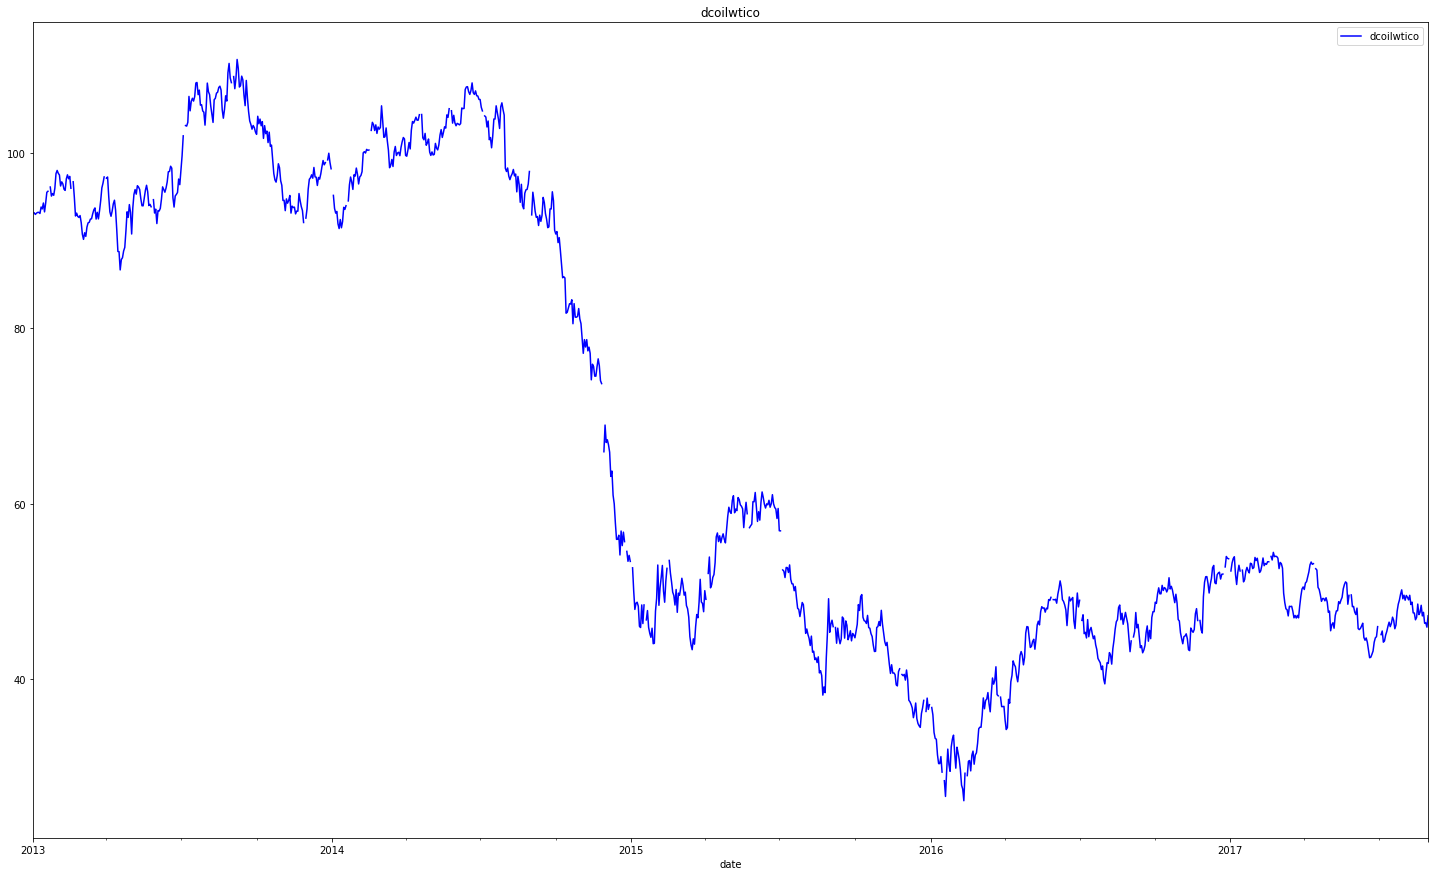

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25,15))
df_oil.plot.line(x="date", y="dcoilwtico", color='b', title ="dcoilwtico", ax = axes, rot=0)
plt.show()

As we have so much rows in out dataset, it will be easier to group data, as example, by week or month. The aggregation will be made by **mean**.

In [12]:
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

Here we can **check grouped data**:

In [13]:
# check grouped data
df_grouped_trans_w = grouped(df_trans, 'date', 'W', 'transactions')
df_grouped_trans_w

date         mean
0   2013-01-06  1883.203463
1   2013-01-13  1641.090062
2   2013-01-20  1639.024845
3   2013-01-27  1609.816770
4   2013-02-03  1685.263975
..         ...          ...
237 2017-07-23  1623.208995
238 2017-07-30  1619.653439
239 2017-08-06  1713.743386
240 2017-08-13  1599.156085
241 2017-08-20  1592.675926

[242 rows x 2 columns]

And, for better forecasting we'll add ***'time'*** column to our dataframe.

In [14]:
def add_time(df, key, freq, col):
    """ ADD COLUMN 'TIME' TO DF """
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

So, now we can check the results of grouping on the example of **df_train (grouped by weeks on sales, after that, mean was counted)**.

In [15]:
df_grouped_train_w = add_time(df_train, 'date', 'W', 'sales')
df_grouped_train_m = add_time(df_train, 'date', 'M', 'sales')

df_grouped_train_w.head() # check results

date  time        mean
0 2013-01-06     0  206.843478
1 2013-01-13     1  190.285220
2 2013-01-20     2  189.835452
3 2013-01-27     3  182.152050
4 2013-02-03     4  198.564267

# 3.1. Linear Regression
After that, we can build some more plots. **Linear regression** is widely used in practice and adapts naturally to even complex forecasting tasks. The linear regression algorithm learns how to make a weighted sum from its input features.

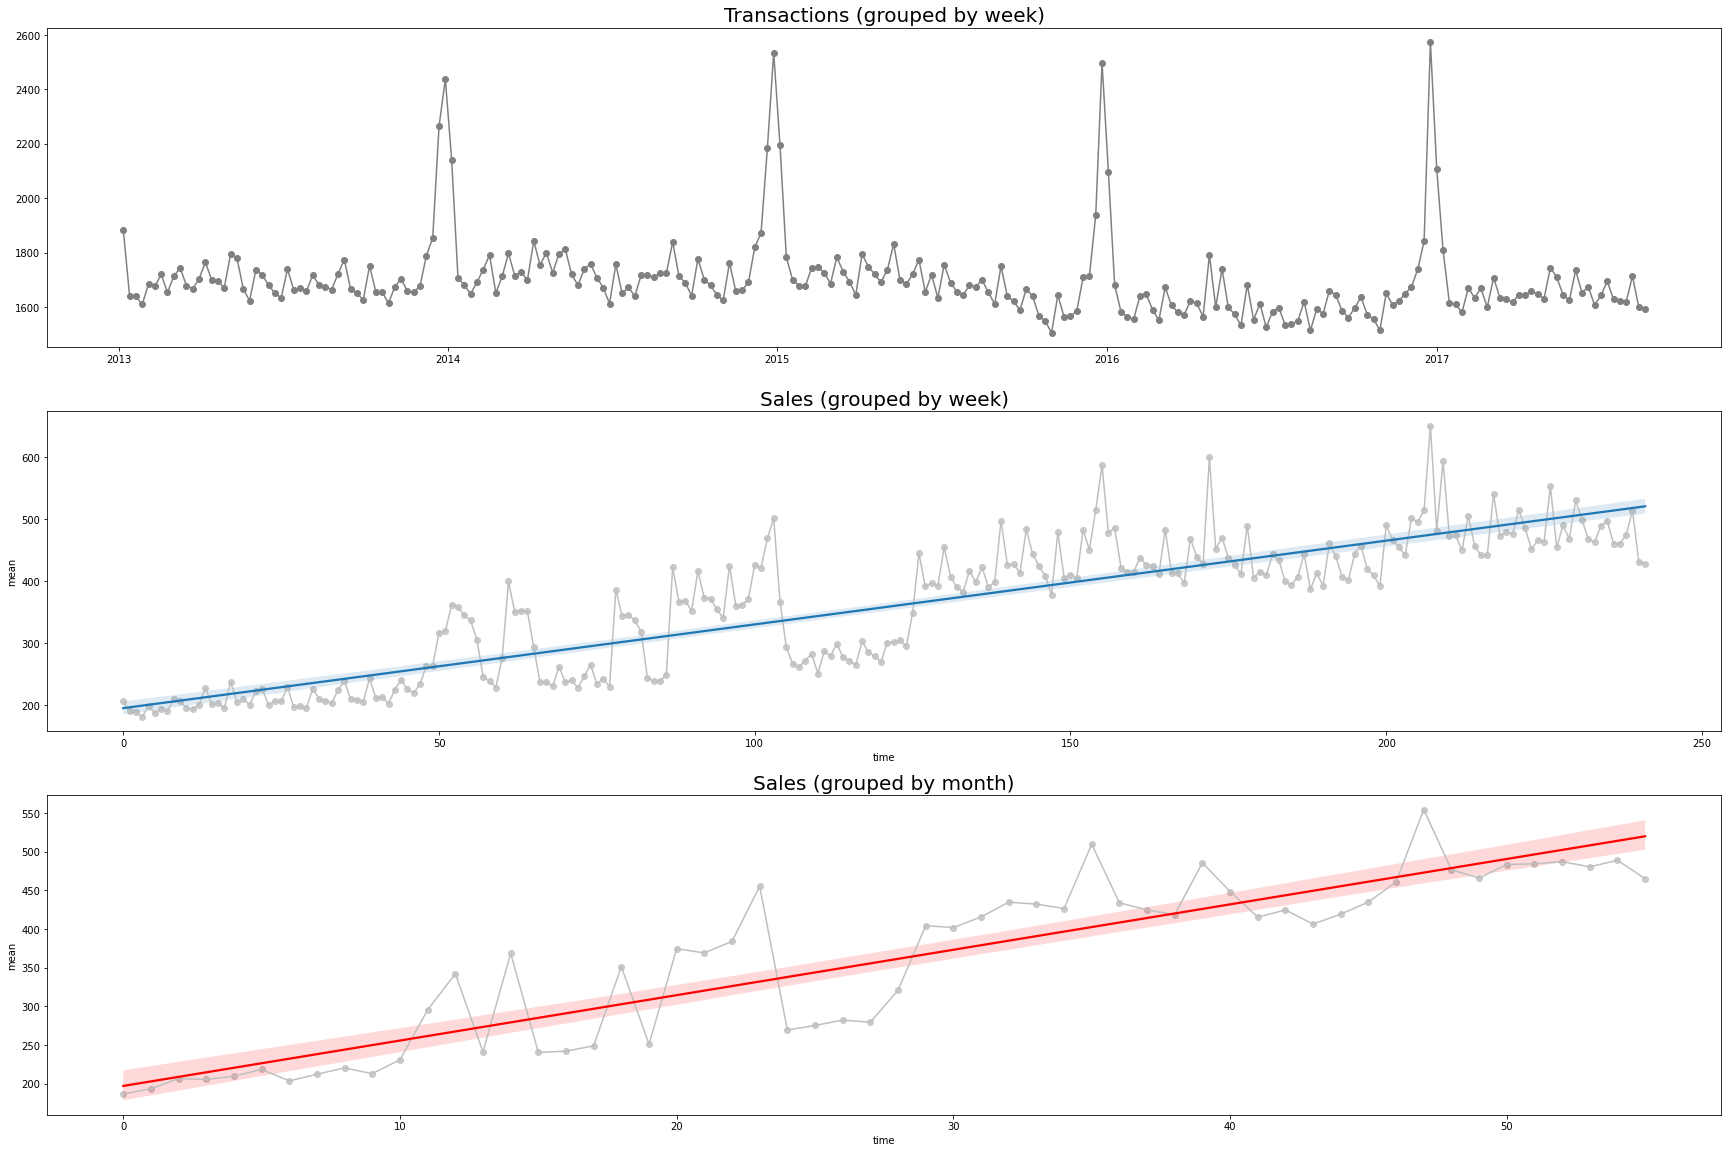

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30,20))

# TRANSACTIONS (WEEKLY)
axes[0].plot('date', 'mean', data=df_grouped_trans_w, color='grey', marker='o')
axes[0].set_title("Transactions (grouped by week)", fontsize=20)

# SALES (WEEKLY)
axes[1].plot('time', 'mean', data=df_grouped_train_w, color='0.75')
axes[1].set_title("Sales (grouped by week)", fontsize=20)
# linear regression
axes[1] = sns.regplot(x='time', 
                      y='mean', 
                      data=df_grouped_train_w, 
                      scatter_kws=dict(color='0.75'), 
                      ax = axes[1])

# SALES (MONTHLY)
axes[2].plot('time', 'mean', data=df_grouped_train_m, color='0.75')
axes[2].set_title("Sales (grouped by month)", fontsize=20)
# linear regression
axes[2] = sns.regplot(x='time', 
                      y='mean', 
                      data=df_grouped_train_m, 
                      scatter_kws=dict(color='0.75'), 
                      line_kws={"color": "red"},
                      ax = axes[2])

plt.show()

# 3.2 Lag feature
To make a lag feature we shift the observations of the target series so that they appear to have occured later in time. Here we've created a 1-step lag feature, though shifting by multiple steps is possible too. So, firstly, we should **add lag** to our data:

In [17]:
def add_lag(df, key, freq, col, lag):
    """ ADD LAG """
    df_grouped = grouped(df, key, freq, col)
    name = 'Lag_' + str(lag)
    df_grouped['Lag'] = df_grouped['mean'].shift(lag)
    return df_grouped

Here we can **check grouped data with lag**:

In [18]:
df_grouped_train_w_lag1 = add_lag(df_train, 'date', 'W', 'sales', 1)
df_grouped_train_m_lag1 = add_lag(df_train, 'date', 'W', 'sales', 1)

df_grouped_train_w_lag1.head() # check data

date        mean         Lag
0 2013-01-06  206.843478         NaN
1 2013-01-13  190.285220  206.843478
2 2013-01-20  189.835452  190.285220
3 2013-01-27  182.152050  189.835452
4 2013-02-03  198.564267  182.152050

So lag features let us fit curves to lag plots where each observation in a series is plotted against the previous observation. Let's build same plots, but with ***'lag'*** feature:

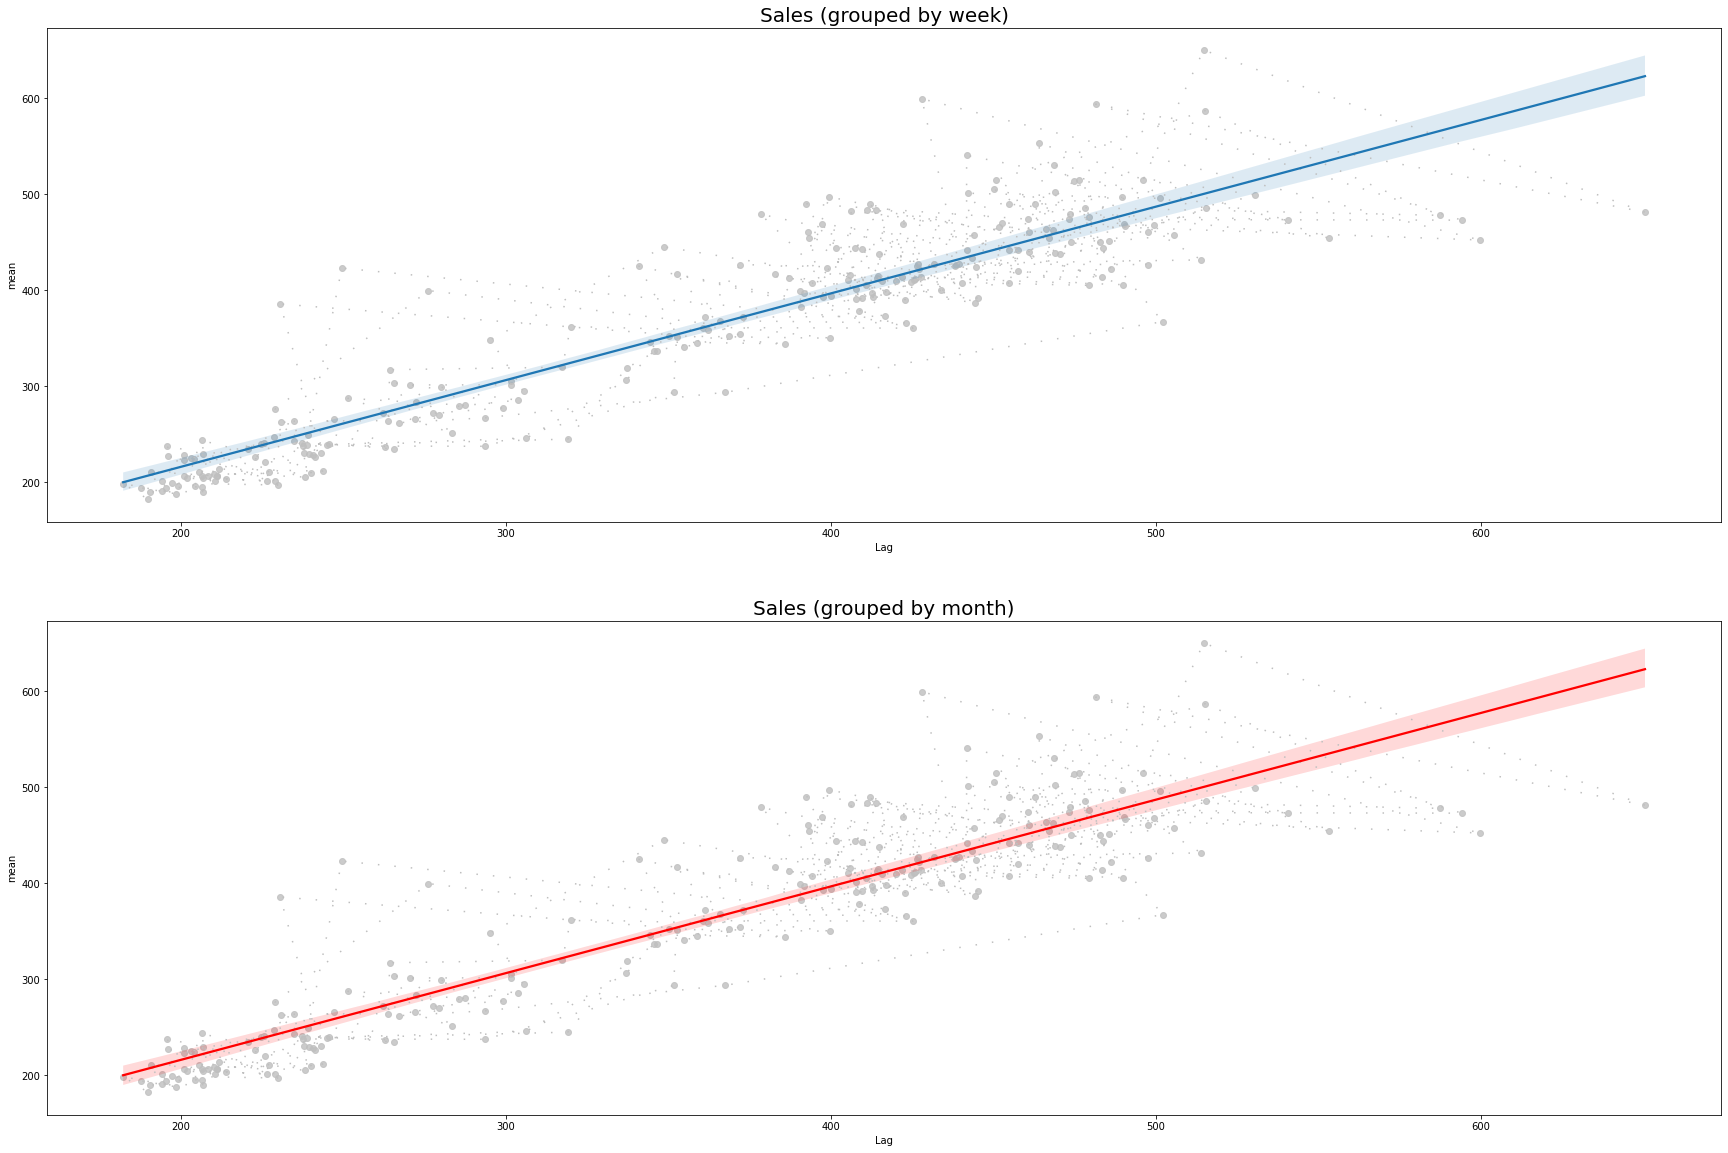

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,20))
axes[0].plot('Lag', 'mean', data=df_grouped_train_w_lag1, color='0.75', linestyle=(0, (1, 10)))
axes[0].set_title("Sales (grouped by week)", fontsize=20)
axes[0] = sns.regplot(x='Lag', 
                      y='mean', 
                      data=df_grouped_train_w_lag1, 
                      scatter_kws=dict(color='0.75'), 
                      ax = axes[0])


axes[1].plot('Lag', 'mean', data=df_grouped_train_m_lag1, color='0.75', linestyle=(0, (1, 10)))
axes[1].set_title("Sales (grouped by month)", fontsize=20)
axes[1] = sns.regplot(x='Lag', 
                      y='mean', 
                      data=df_grouped_train_m_lag1, 
                      scatter_kws=dict(color='0.75'), 
                      line_kws={"color": "red"},
                      ax = axes[1])

plt.show()

# 3.3 Some more statistics & visualizations
In this block we are going to explore data. Firstly, let's count for each category in each dataset, ***value_counts()***:

In [20]:
def plot_stats(df, column, ax, color, angle):
    """ PLOT STATS OF DIFFERENT COLUMNS """
    count_classes = df[column].value_counts()
    ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
    ax.set_title(column.upper(), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

Here we can see stats for **df_holidays**:

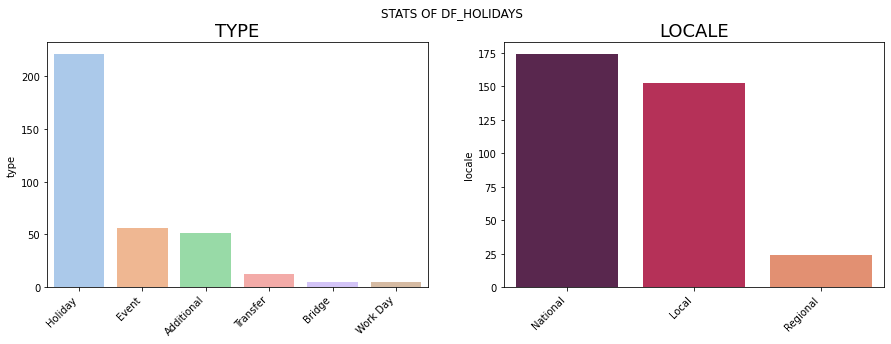

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
fig.autofmt_xdate()
fig.suptitle("Stats of df_holidays".upper())
plot_stats(df_holidays, "type", axes[0], "pastel", 45)
plot_stats(df_holidays, "locale", axes[1], "rocket", 45)
plt.show()

Here we count values for some columns of **df_stores**:

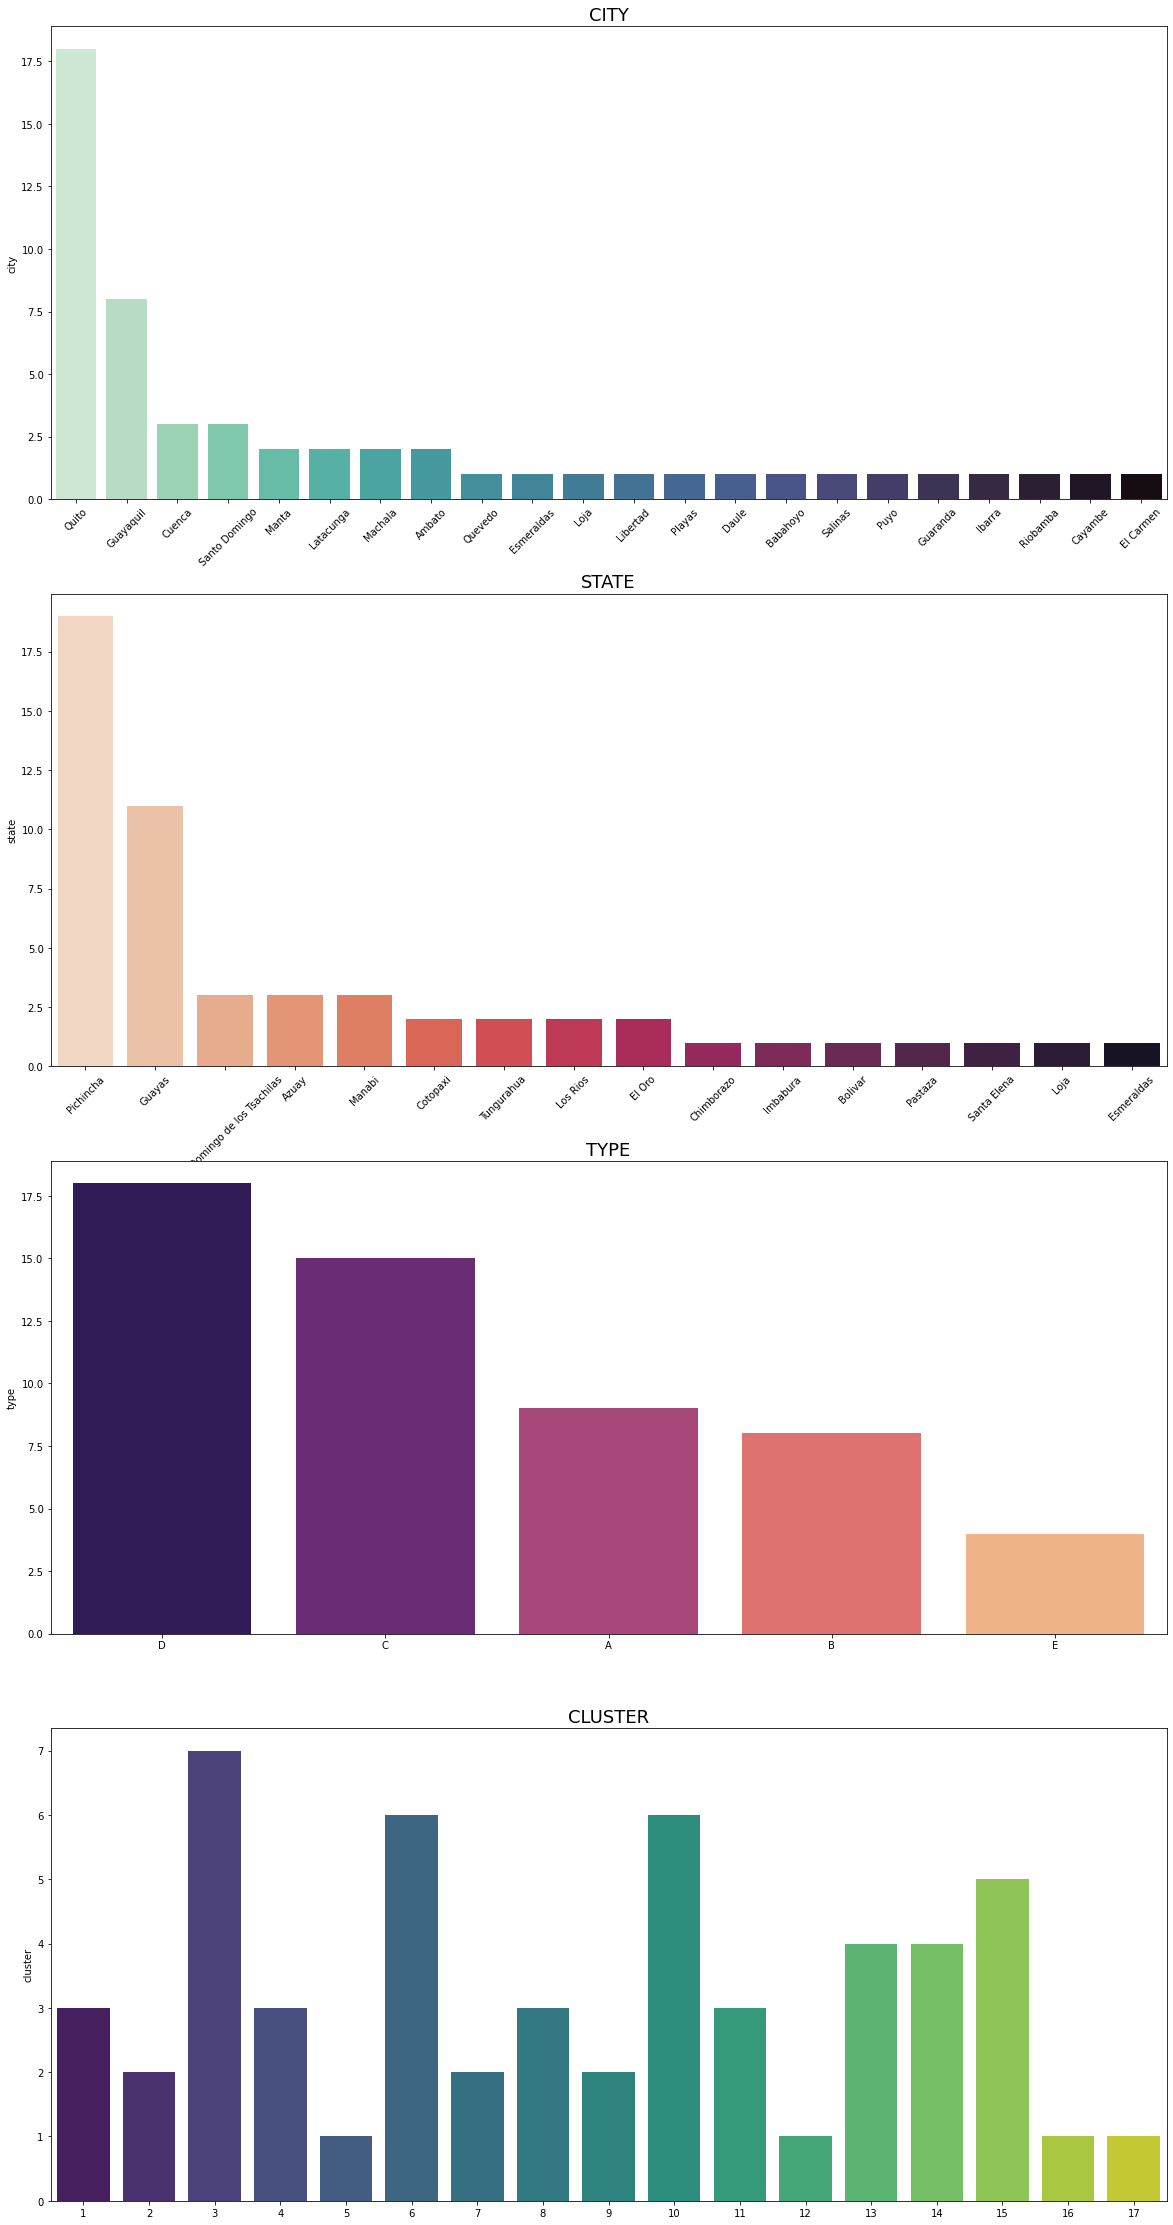

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20,40))
plot_stats(df_stores, "city", axes[0], "mako_r", 45)
plot_stats(df_stores, "state", axes[1], "rocket_r", 45)
plot_stats(df_stores, "type", axes[2], "magma", 0)
plot_stats(df_stores, "cluster", axes[3], "viridis", 0)
plt.show()

Let's plot **pie chart** for ***'family'*** of **df_train**:

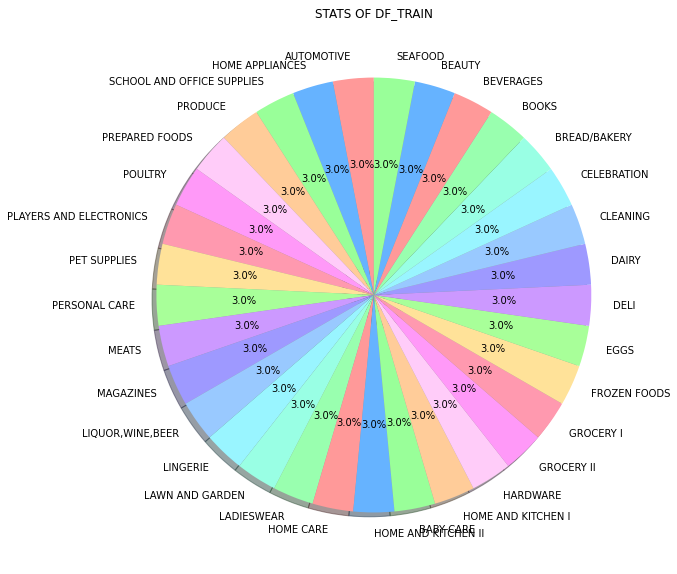

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
count_classes = df_train['family'].value_counts()
plt.title("Stats of df_train".upper())
colors = ['#ff9999','#66b3ff','#99ff99',
          '#ffcc99', '#ffccf9', '#ff99f8', 
          '#ff99af', '#ffe299', '#a8ff99',
          '#cc99ff', '#9e99ff', '#99c9ff',
          '#99f5ff', '#99ffe4', '#99ffaf']

plt.pie(count_classes, 
        labels = count_classes.index, 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90, 
        colors=colors)

plt.show()

# 3.4 BoxPlot
In addition, we can build some **boxplots**: for **df_oil** & **df_trans**.

In [24]:
def plot_boxplot(palette, x, y, hue, ax, title):
    sns.set_theme(style="ticks", palette=palette)
    ax = sns.boxplot(x=x, y=y, hue=hue, ax=ax)
    ax.set_title(title, fontsize=18)

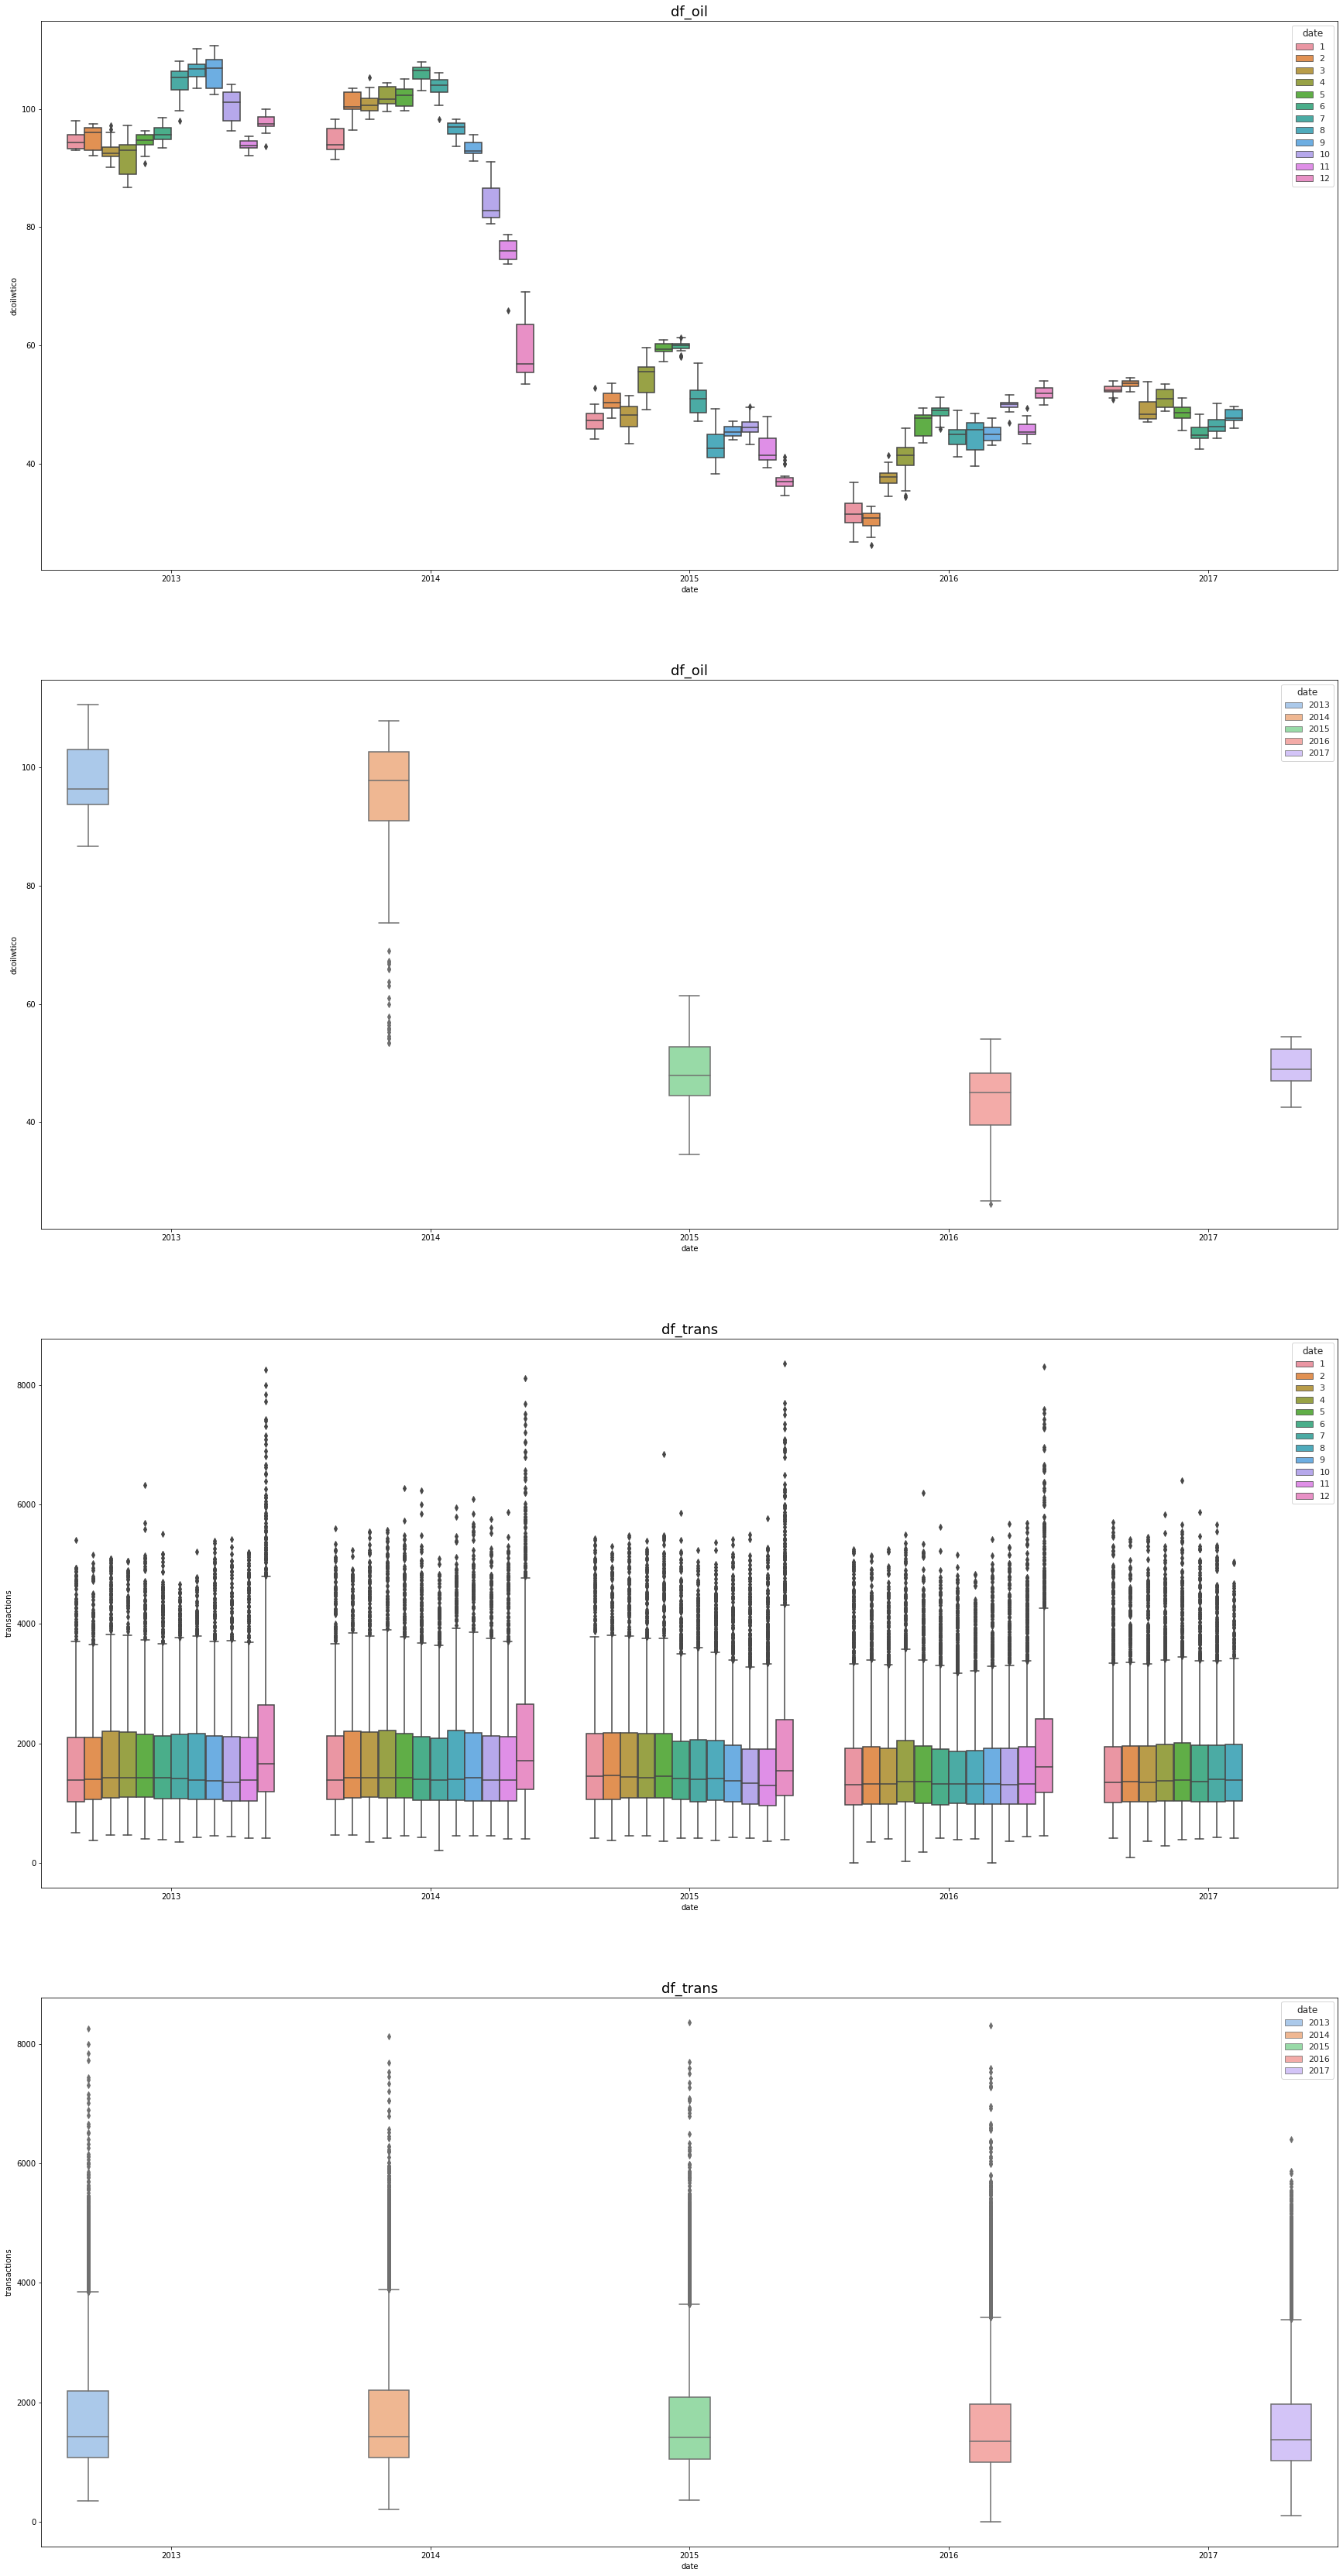

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30,60))
plot_boxplot("pastel", df_oil['date'].dt.year, df_oil['dcoilwtico'], df_oil['date'].dt.month, axes[0], "df_oil")
plot_boxplot("pastel", df_oil['date'].dt.year, df_oil['dcoilwtico'], df_oil['date'].dt.year, axes[1], "df_oil")
plot_boxplot("pastel", df_trans['date'].dt.year, df_trans['transactions'], df_trans['date'].dt.month, axes[2], "df_trans")
plot_boxplot("pastel", df_trans['date'].dt.year, df_trans['transactions'], df_trans['date'].dt.year, axes[3], "df_trans")
plt.show()

# 3.5 Trend. Moving Average
The **trend** component of a time series represents a persistent, long-term change in the mean of the series. The trend is the slowest-moving part of a series, the part representing the largest time scale of importance. In a time series of product sales, an increasing trend might be the effect of a market expansion as more people become aware of the product year by year.

To see what kind of trend a time series might have, we can use a **moving average** plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

Below we can see the moving average plots for **Transactions** and **Sales**, colored in green.

In [26]:
def plot_moving_average(df, key, freq, col, window, min_periods, ax, title):
    df_grouped = grouped(df, key, freq, col)
    moving_average = df_grouped['mean'].rolling(window=window, center=True, min_periods=min_periods).mean()   
    ax = df_grouped['mean'].plot(color='0.75', linestyle='dashdot', ax=ax)
    ax = moving_average.plot(linewidth=3, color='g', ax=ax)
    ax.set_title(title, fontsize=18)

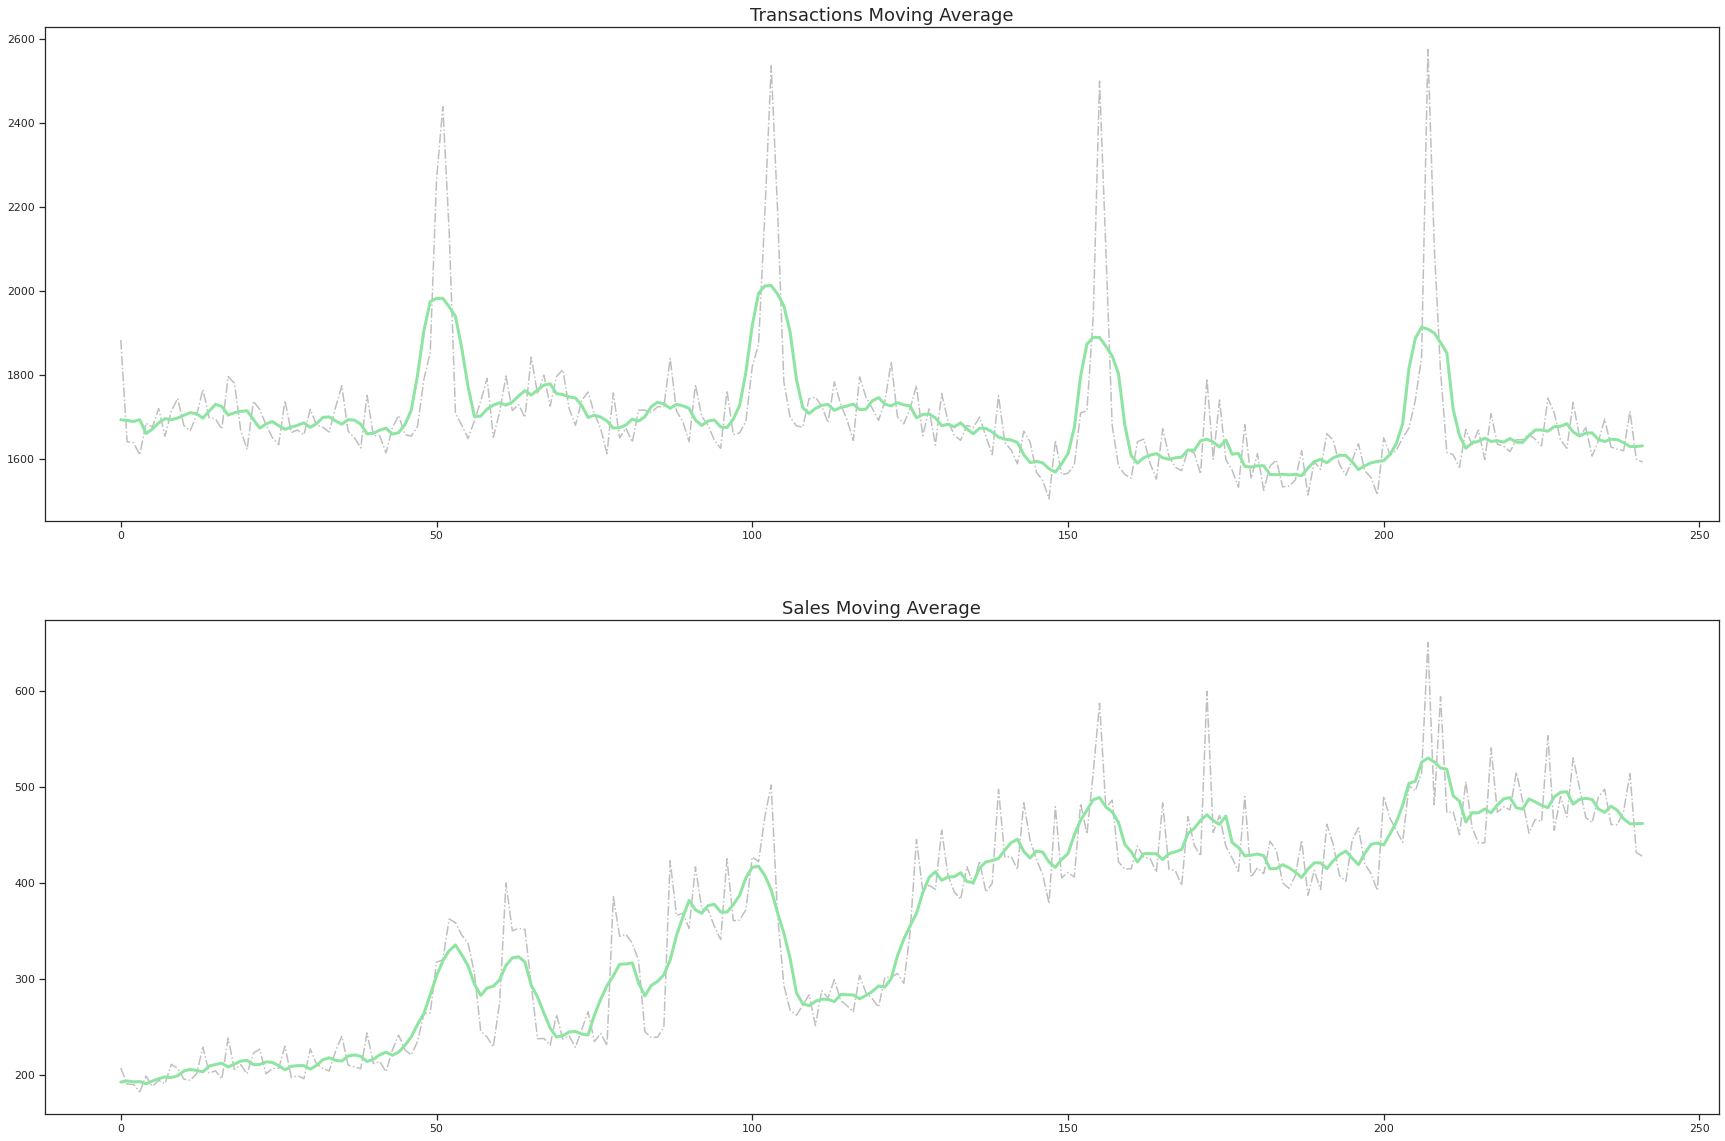

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,20))
plot_moving_average(df_trans, 'date', 'W', 'transactions', 7, 4, axes[0], 'Transactions Moving Average')
plot_moving_average(df_train, 'date', 'W', 'sales', 7, 4, axes[1], 'Sales Moving Average')
plt.show()

# 3.6. Trend. Forecasting Trend
We'll use a function from the **statsmodels** library called **DeterministicProcess**. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [28]:
def plot_deterministic_process(df, key, freq, col, ax1, title1, ax2, title2):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
    dp = DeterministicProcess(index=df_grouped['date'], constant=True, order=1, drop=True)
    dp.index.freq = freq # manually set the frequency of the index
    # 'in_sample' creates features for the dates given in the `index` argument
    X1 = dp.in_sample()
    y1 = df_grouped["mean"]  # the target
    y1.index = X1.index
    # The intercept is the same as the `const` feature from
    # DeterministicProcess. LinearRegression behaves badly with duplicated
    # features, so we need to be sure to exclude it here.
    model = LinearRegression(fit_intercept=False)
    model.fit(X1, y1)
    y1_pred = pd.Series(model.predict(X1), index=X1.index)
    ax1 = y1.plot(linestyle='dashed', label="mean", color="0.75", ax=ax1, use_index=True)
    ax1 = y1_pred.plot(linewidth=3, label="Trend", color='b', ax=ax1, use_index=True)
    ax1.set_title(title1, fontsize=18)  
    _ = ax1.legend()
    
    # forecast Trend for future 30 steps
    steps = 30 
    X2 = dp.out_of_sample(steps=steps)
    y2_fore = pd.Series(model.predict(X2), index=X2.index)
    y2_fore.head()
    ax2 = y1.plot(linestyle='dashed', label="mean", color="0.75", ax=ax2, use_index=True)
    ax2 = y1_pred.plot(linewidth=3, label="Trend", color='b', ax=ax2, use_index=True)
    ax2 = y2_fore.plot(linewidth=3, label="Predicted Trend", color='r', ax=ax2, use_index=True)
    ax2.set_title(title2, fontsize=18)  
    _ = ax2.legend()

Here we can see **Linear Trend** & **Linear Trend Forecast** for **Transactions** (plots 1,2) and **Sales** (plots 3,4).

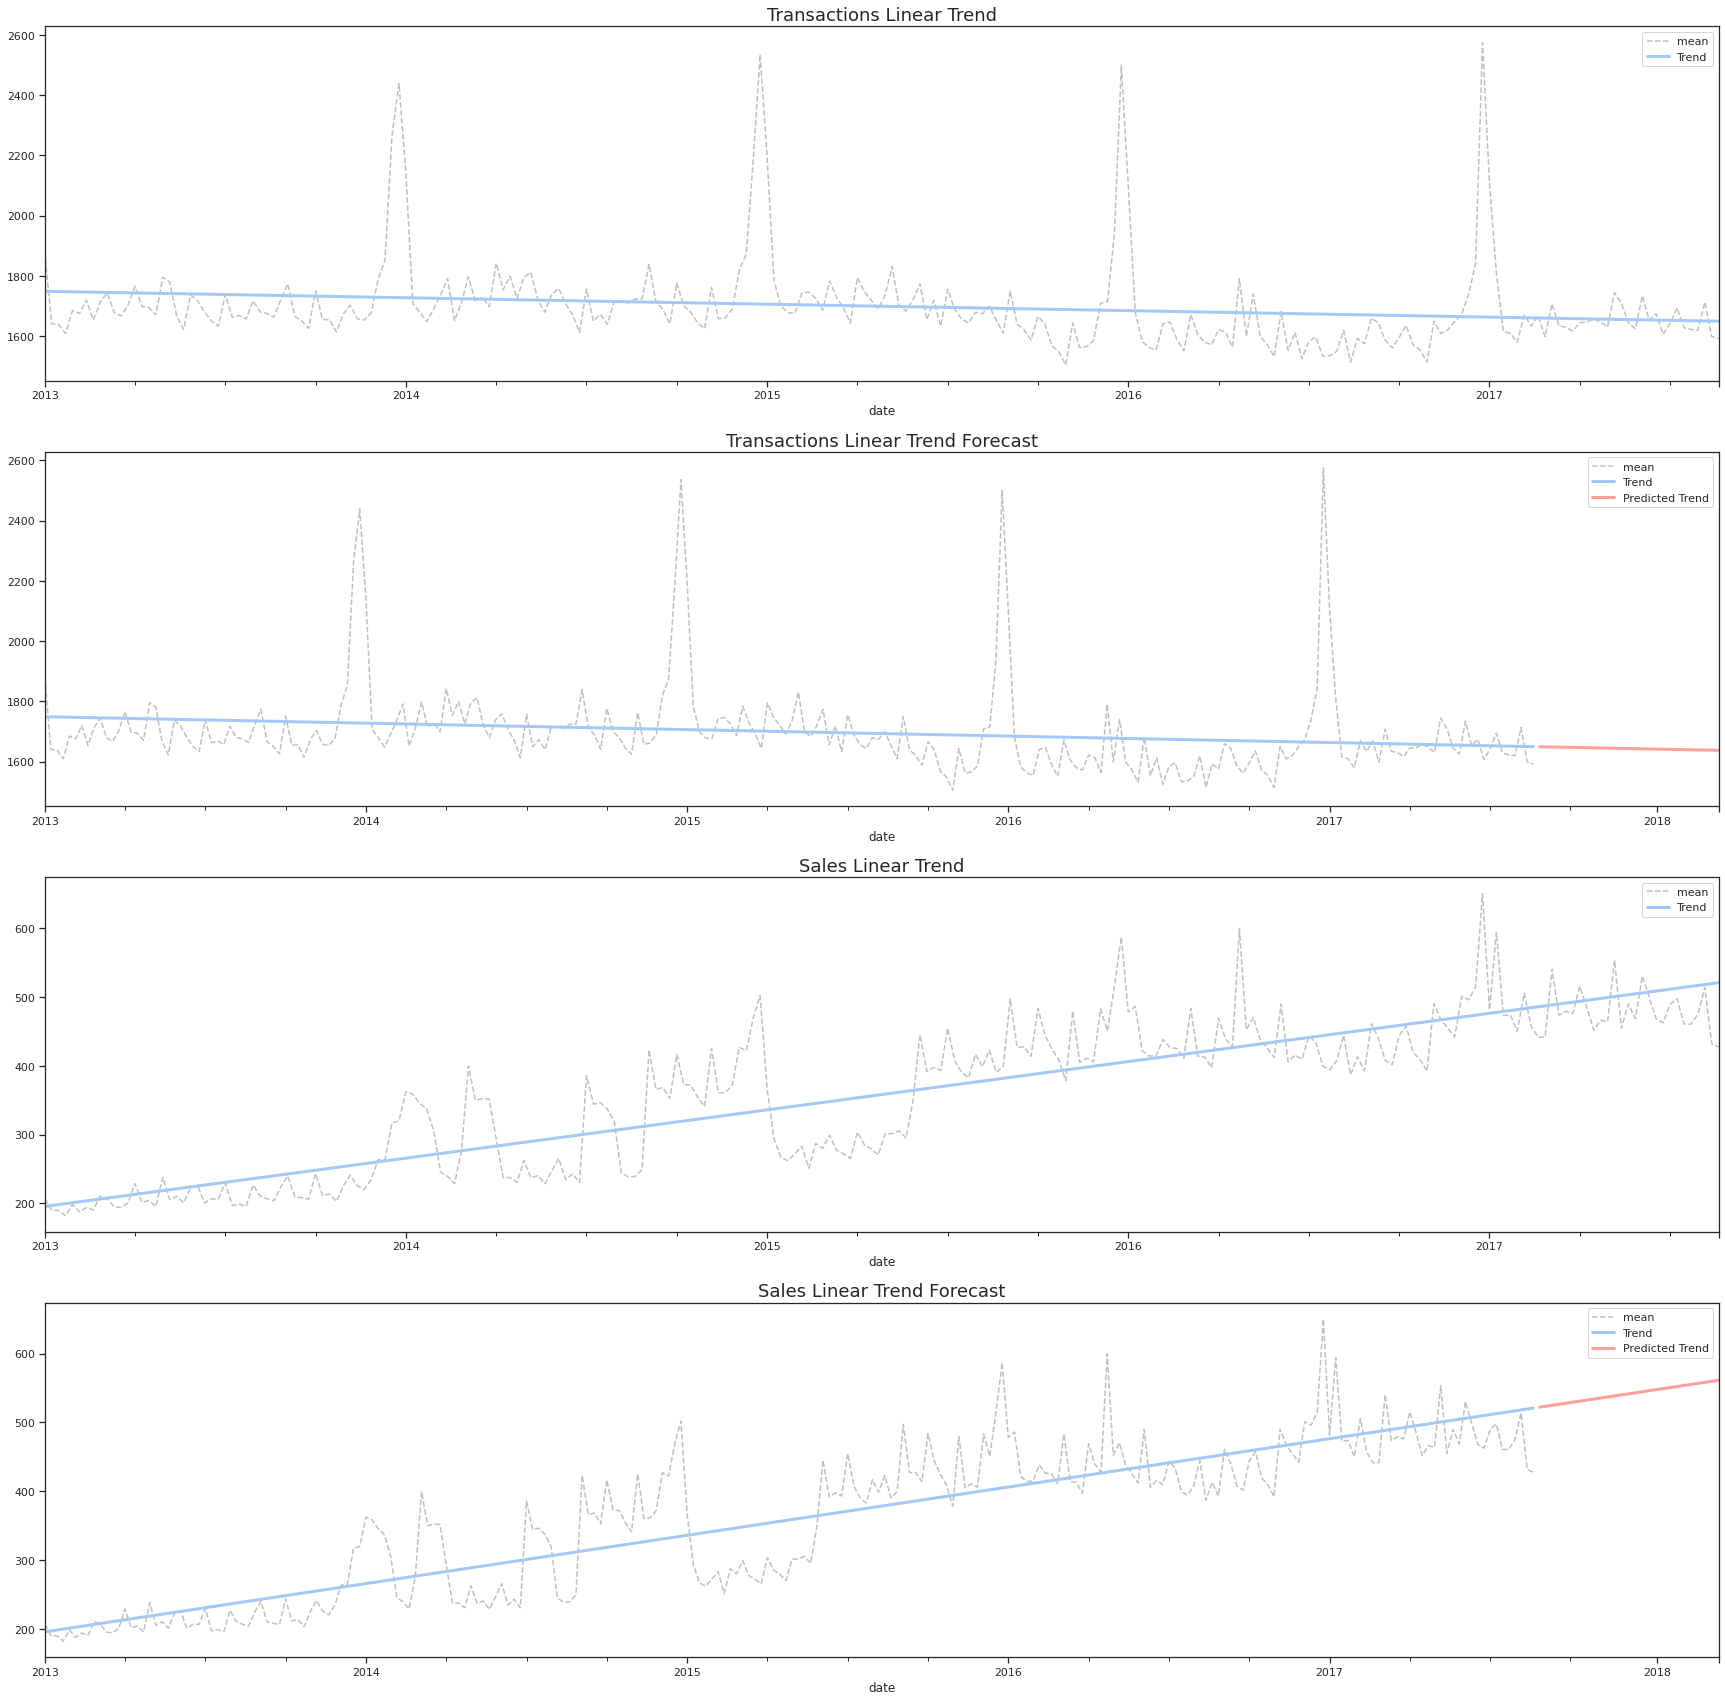

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(30,30))
plot_deterministic_process(df_trans, 'date', 'W', 'transactions', 
                           axes[0], "Transactions Linear Trend",  
                           axes[1], "Transactions Linear Trend Forecast")
plot_deterministic_process(df_train, 'date', 'W', 'sales', 
                           axes[2], "Sales Linear Trend", 
                           axes[3], "Sales Linear Trend Forecast")
plt.show()

# 3.7 Seasonality
Time series exhibits **seasonality** whenever there is a regular, periodic change in the mean of the series. Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times. Just like we used a moving average plot to discover the trend in a series, we can use a **seasonal plot** to discover seasonal patterns.

In [30]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(x=X[freq], 
                      y=X[y],
                      ax=ax, 
                      hue=X[period],
                      palette=palette, 
                      legend=False)
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(name, 
                    xy=(1, y_), 
                    xytext=(6, 0), 
                    color=line.get_color(), 
                    xycoords=ax.get_yaxis_transform(), 
                    textcoords="offset points", 
                    size=14, 
                    va="center")
    return ax

In [31]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [32]:
def seasonality(df, key, freq, col):
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d")
    df_grouped.index = df_grouped['date'] 
    df_grouped = df_grouped.drop(columns=['date'])
    df_grouped.index.freq = freq # manually set the frequency of the index
    
    X = df_grouped.copy()
    X.index = pd.to_datetime(X.index, format = "%Y-%m-%d") 
    X.index.freq = freq 
    # days within a week
    X["day"] = X.index.dayofweek   # the x-axis (freq)
    X["week"] = pd.Int64Index(X.index.isocalendar().week)  # the seasonal period (period)
    # days within a year
    X["dayofyear"] = X.index.dayofyear
    X["year"] = X.index.year
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(20, 30))
    seasonal_plot(X, y='mean', period="week", freq="day", ax=ax0)
    seasonal_plot(X, y='mean', period="year", freq="dayofyear", ax=ax1)
    X_new = (X['mean'].copy()).dropna()
    plot_periodogram(X_new, ax=ax2)

Let's take a look at **seasonal plots** over a week and over a year. Here we can see the plots for **df_trans**.

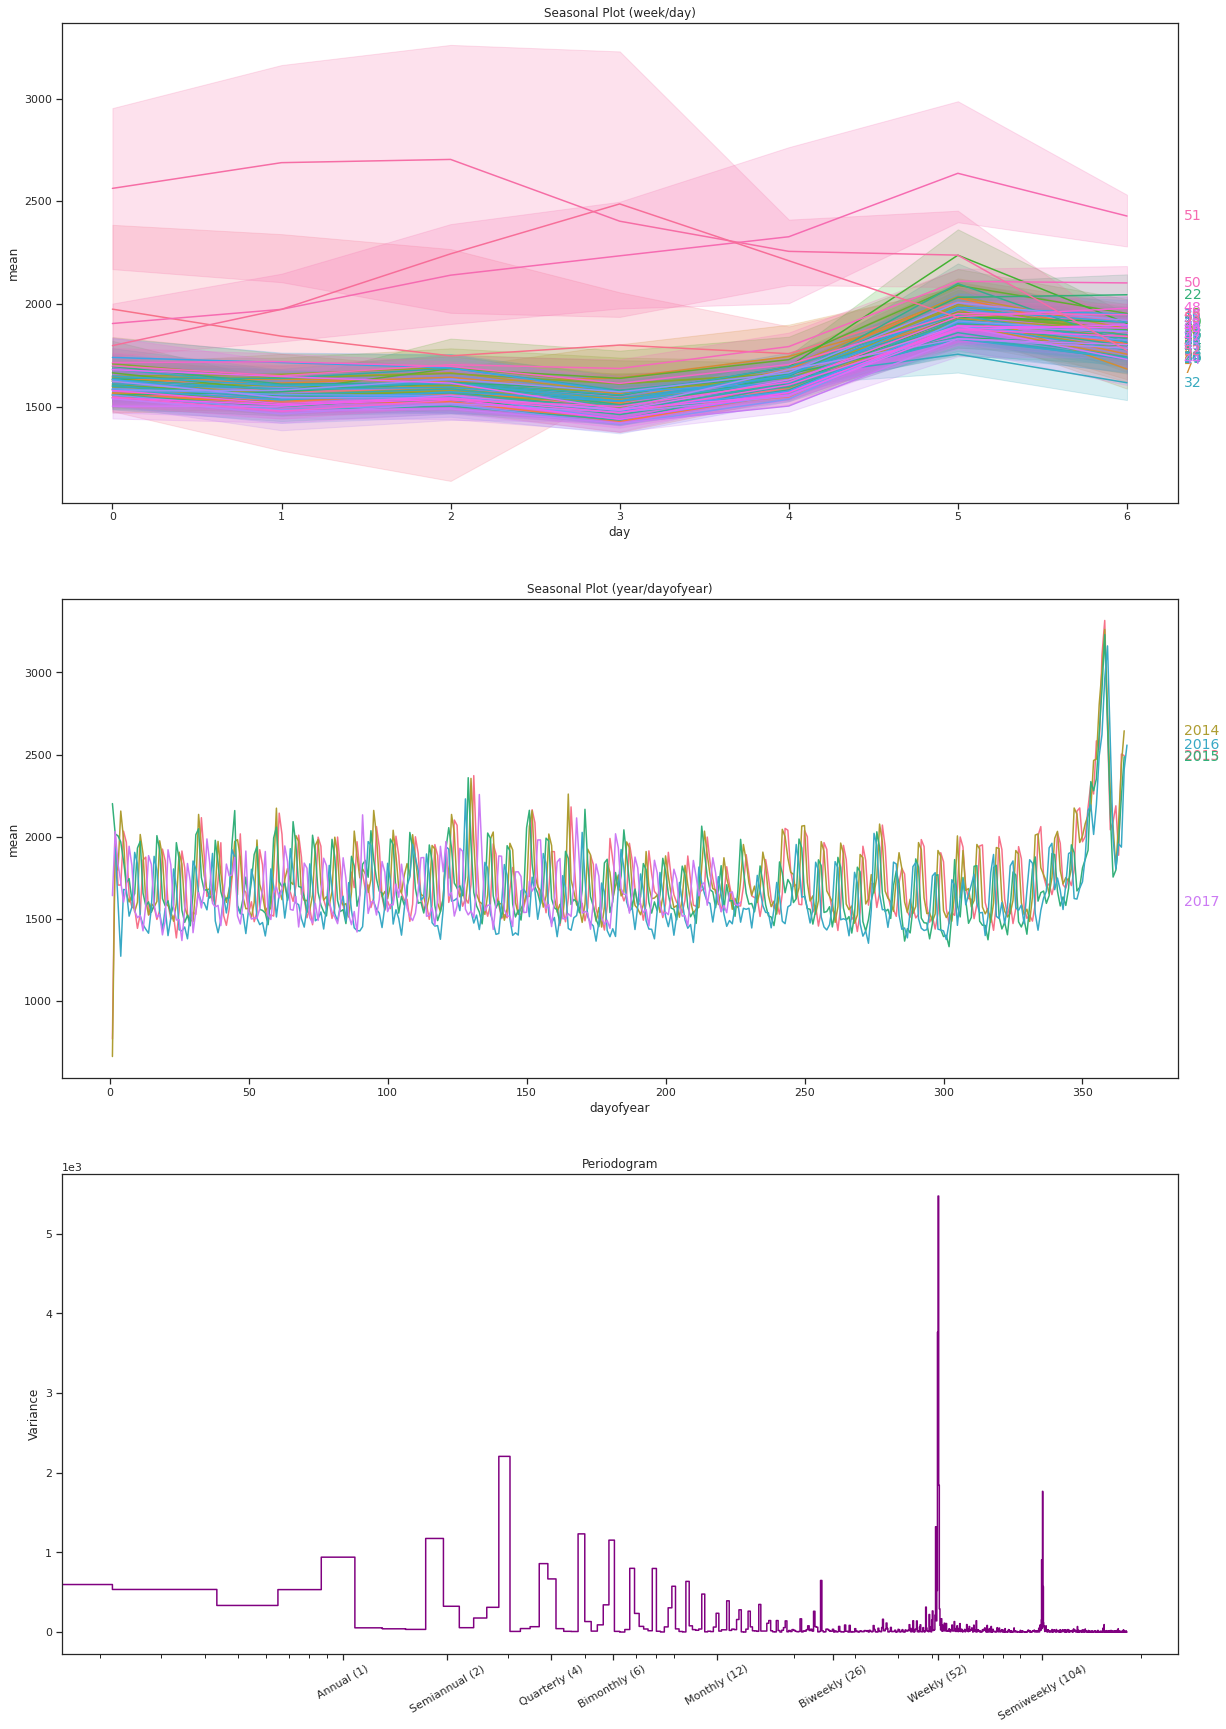

In [33]:
# df_trans, grouped by day
seasonality(df_trans, 'date', 'D', 'transactions')

Here we can see the plots for **df_train**.

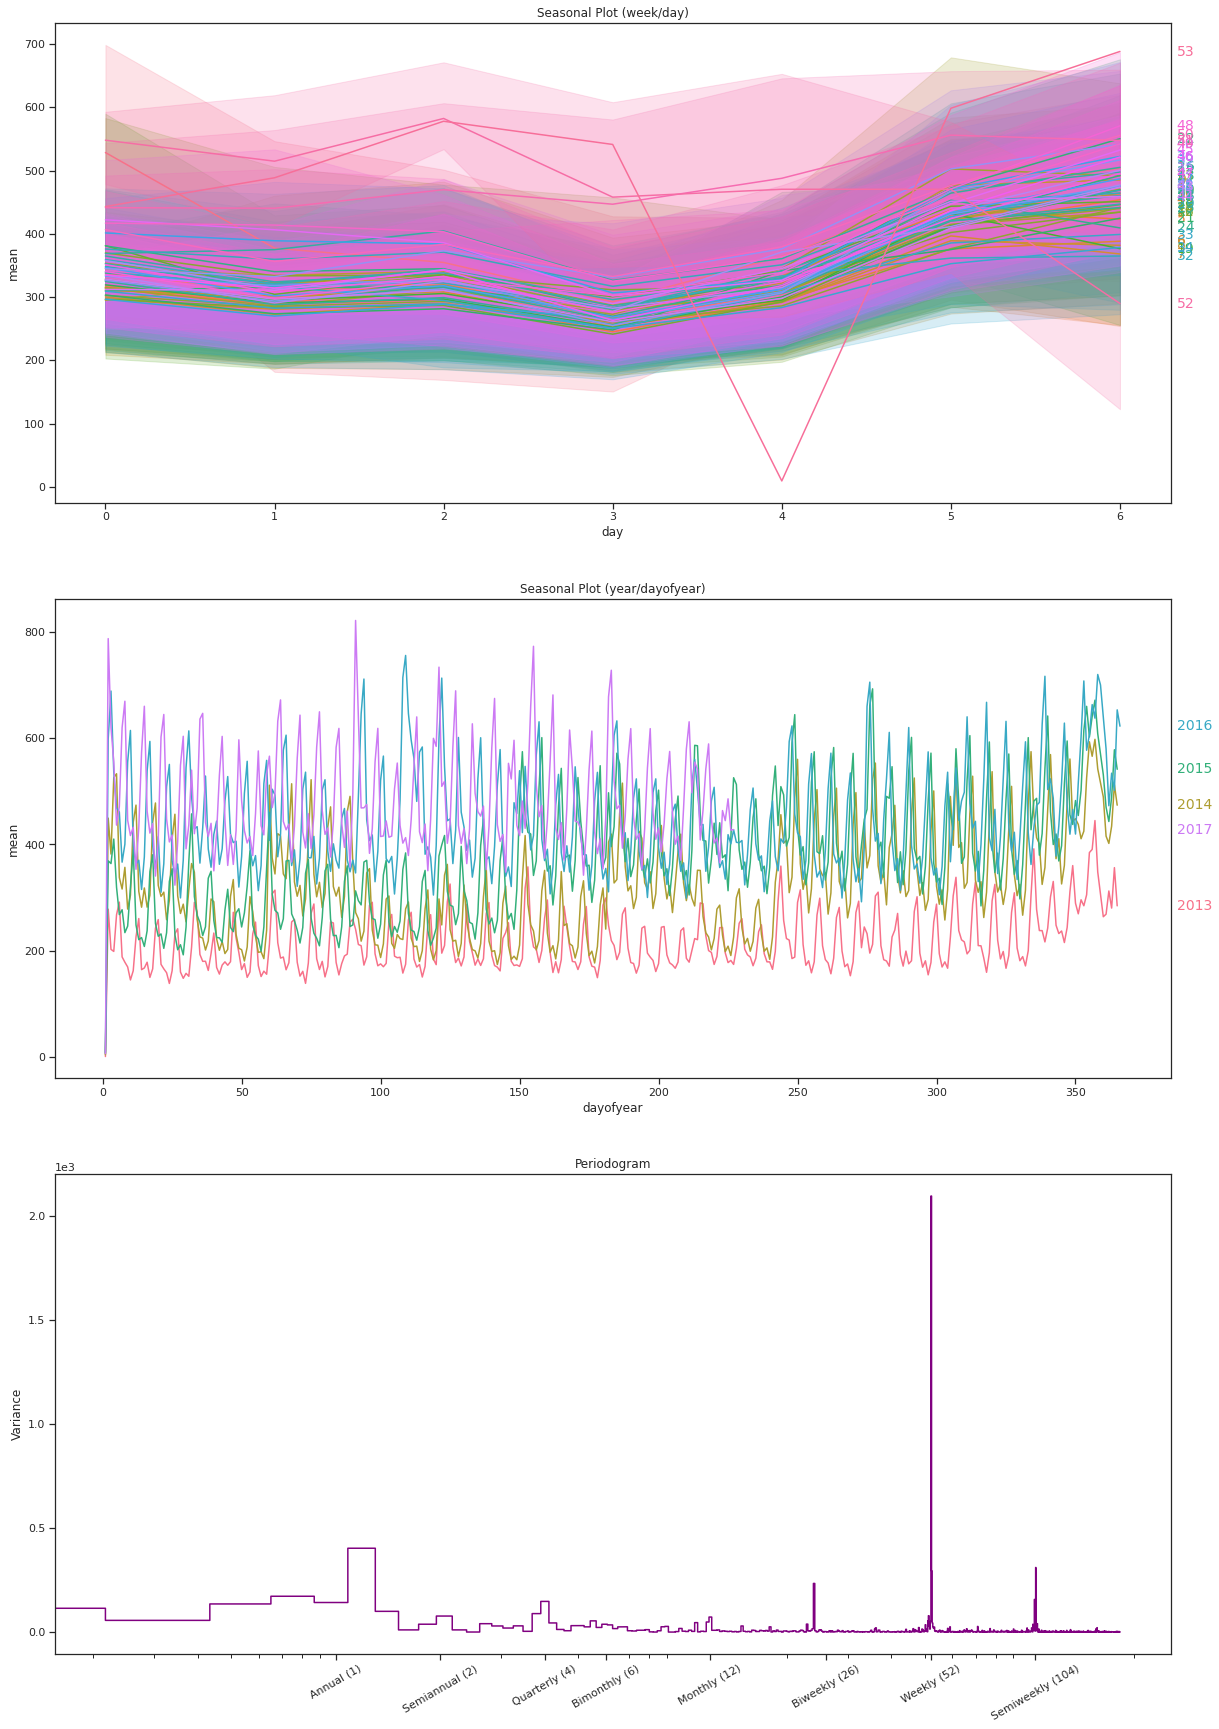

In [34]:
# df_train, grouped by day
seasonality(df_train, 'date', 'D', 'sales')

After that, we can **predict seasonality**, using **DeterministicProcess**, as we used for Trend. We are going to forecast seasonality for **Transactions** and **Sales**.

In [35]:
def predict_seasonality(df, key, freq, col, ax1, title1):
    fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality
    df_grouped = grouped(df, key, freq, col)
    df_grouped['date'] = pd.to_datetime(df_grouped['date'], format = "%Y-%m-%d") 
    df_grouped['date'].freq = freq # manually set the frequency of the index
    dp = DeterministicProcess(index=df_grouped['date'], 
                              constant=True, 
                              order=1, 
                              period=None, 
                              seasonal=True, 
                              additional_terms=[fourier], 
                              drop=True)
    dp.index.freq = freq # manually set the frequency of the index

    # 'in_sample' creates features for the dates given in the `index` argument
    X1 = dp.in_sample()
    y1 = df_grouped["mean"]  # the target
    y1.index = X1.index

    # The intercept is the same as the `const` feature from
    # DeterministicProcess. LinearRegression behaves badly with duplicated
    # features, so we need to be sure to exclude it here.
    model = LinearRegression(fit_intercept=False)
    model.fit(X1, y1)
    y1_pred = pd.Series(model.predict(X1), index=X1.index)
    X1_fore = dp.out_of_sample(steps=90)
    y1_fore = pd.Series(model.predict(X1_fore), index=X1_fore.index)
    
    ax1 = y1.plot(linestyle='dashed', style='.', label="init mean values", color="0.4", ax=ax1, use_index=True)
    ax1 = y1_pred.plot(linewidth=3, label="Seasonal", color='b', ax=ax1, use_index=True)
    ax1 = y1_fore.plot(linewidth=3, label="Seasonal Forecast", color='r', ax=ax1, use_index=True)
    ax1.set_title(title1, fontsize=18)  
    _ = ax1.legend()

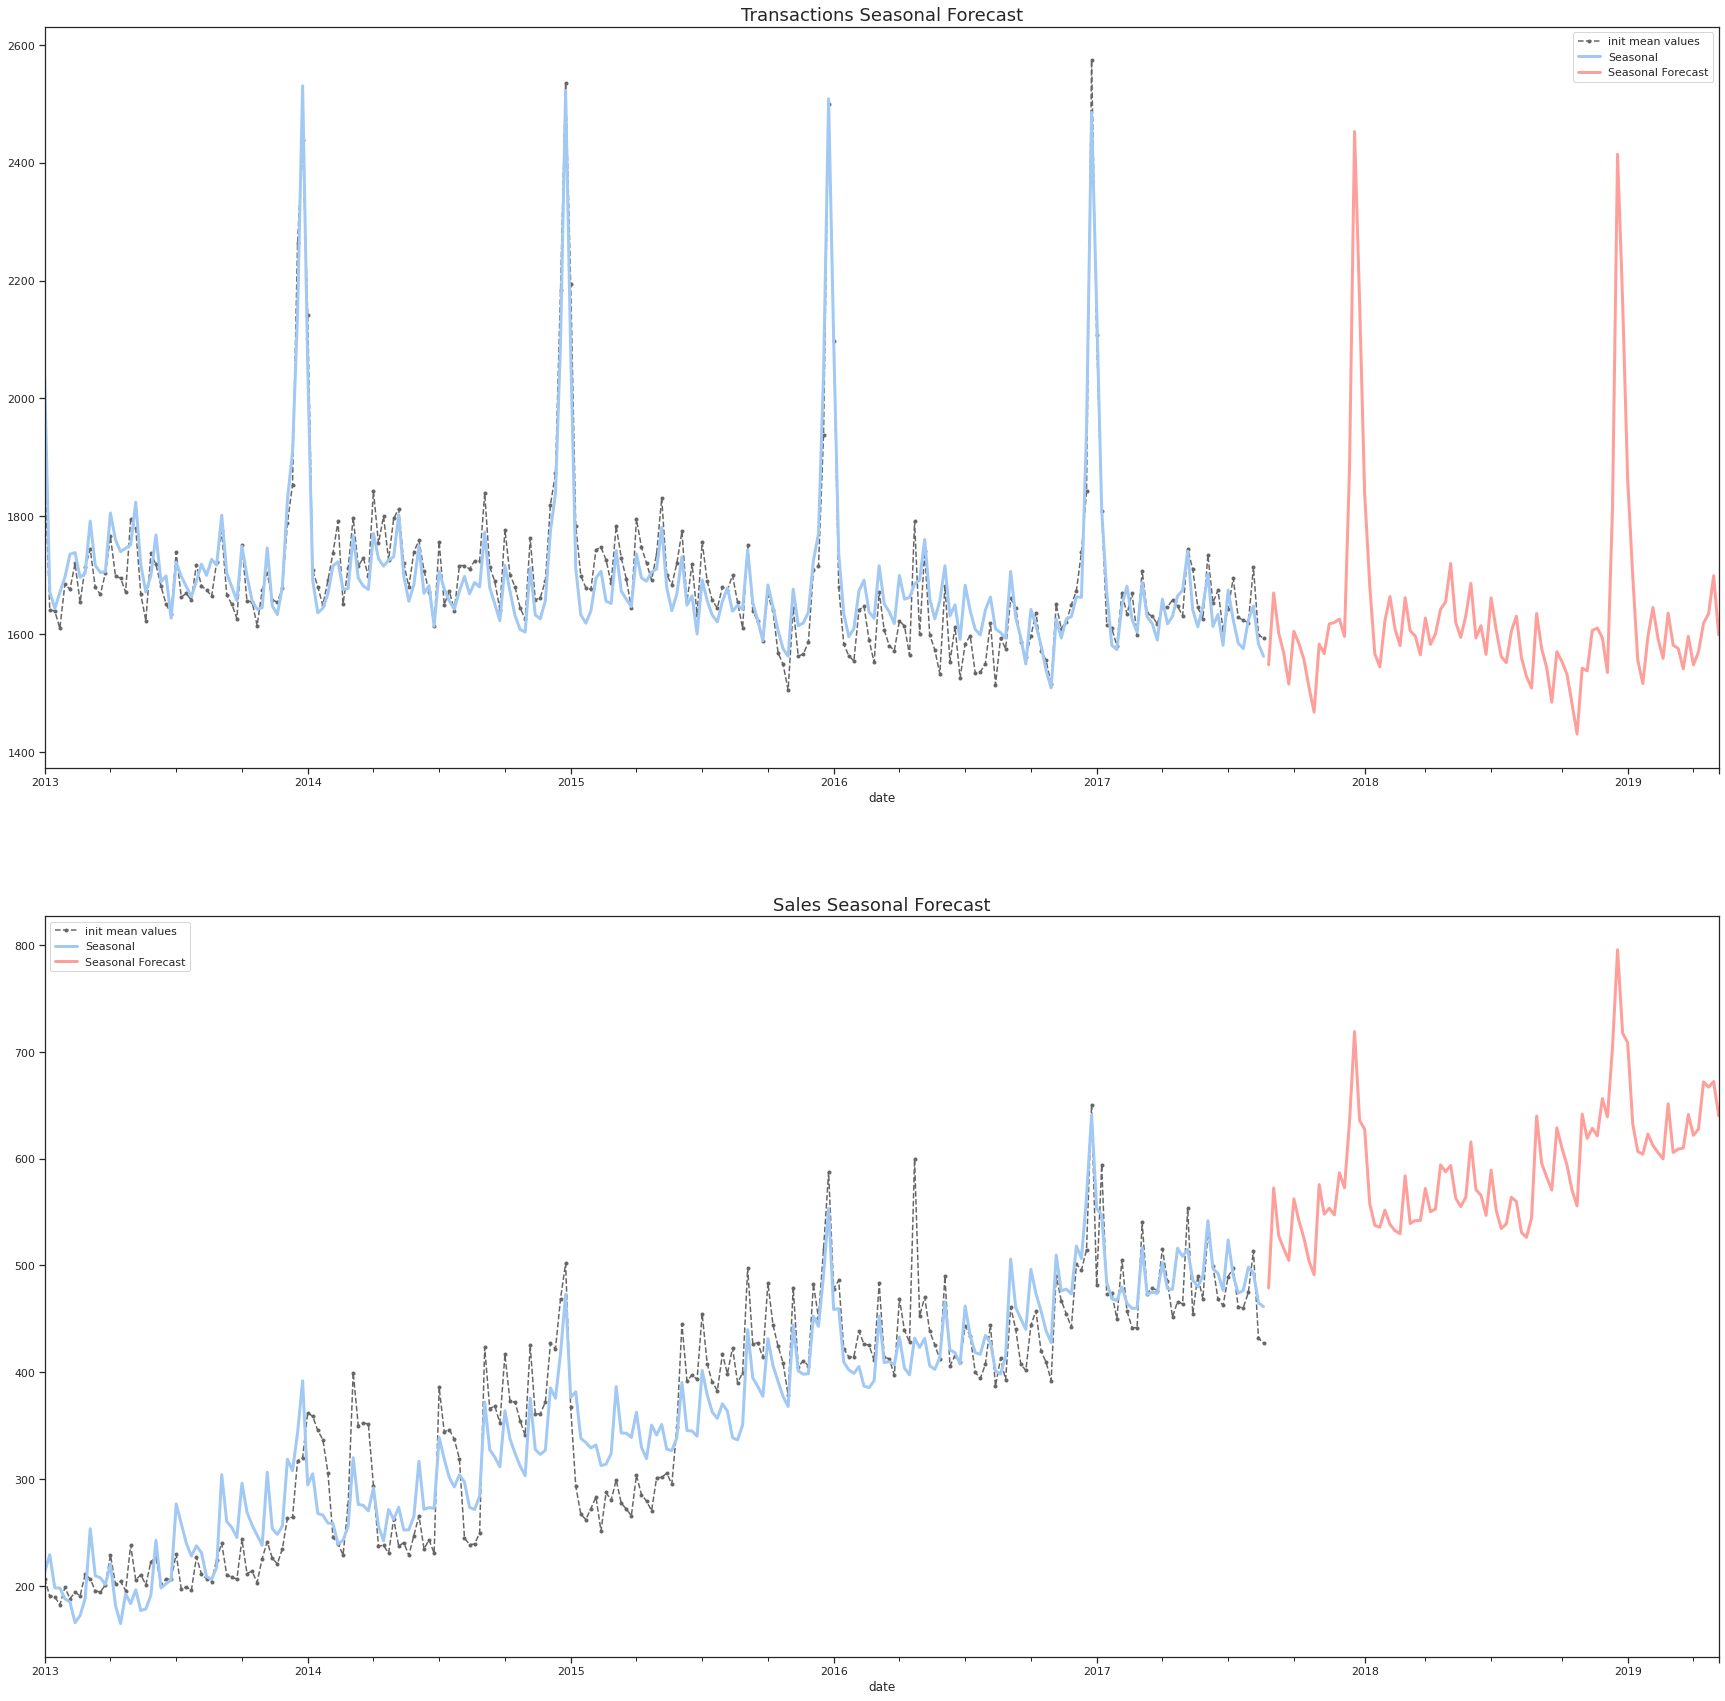

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30,30))
predict_seasonality(df_trans, 'date', 'W', 'transactions', axes[0], "Transactions Seasonal Forecast")
predict_seasonality(df_train, 'date', 'W', 'sales', axes[1], "Sales Seasonal Forecast")
plt.show()

# 4. Time Series as Features

In [37]:
store_sales = df_train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)

mag_sales = family_sales.loc(axis=1)[:, 'MAGAZINES']

Here we can **check data store_sales**:

In [38]:
store_sales.head()

id  sales  onpromotion
store_nbr family     date                                
1         AUTOMOTIVE 2013-01-01     0    0.0          0.0
                     2013-01-02  1782    2.0          0.0
                     2013-01-03  3564    3.0          0.0
                     2013-01-04  5346    3.0          0.0
                     2013-01-05  7128    5.0          0.0

Here we can **check data mag_sales**:

In [39]:
mag_sales.head()

sales onpromotion
family     MAGAZINES   MAGAZINES
date                            
2017-01-01  0.074074    0.074074
2017-01-02  7.777778    2.759259
2017-01-03  3.500000    2.092593
2017-01-04  3.500000    1.833333
2017-01-05  3.203704    1.981481

Here we can **plot data**:

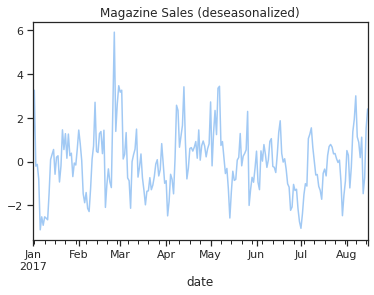

In [40]:
y = mag_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Magazine Sales (deseasonalized)");

By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence. To forecast series, we could use y_lag_1 and y_lag_2 as features to predict the target y.

# 4.1 Lag plot
A lag plot of a time series shows its values plotted against its lags. Serial dependence in a time series will often become apparent by looking at a lag plot. The most commonly used measure of serial dependence is known as **autocorrelation**, which is simply the correlation a time series has with one of its lags. The **partial autocorrelation** tells you the correlation of a lag accounting for all of the previous lags -- the amount of "new" correlation the lag contributes, so to speak. Plotting the partial autocorrelation can help you choose which lag features to use.


In [41]:
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(alpha=0.75,s=3)
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_, y=y_, scatter_kws=scatter_kws, line_kws=line_kws, lowess=True, ax=ax, **kwargs)
    at = AnchoredText(f"{corr:.2f}",prop=dict(size="large"), frameon=True, loc="upper left")
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2 + 10, nrows * 2 + 5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

Let's take a look at the **lag** and **autocorrelation plots** first:

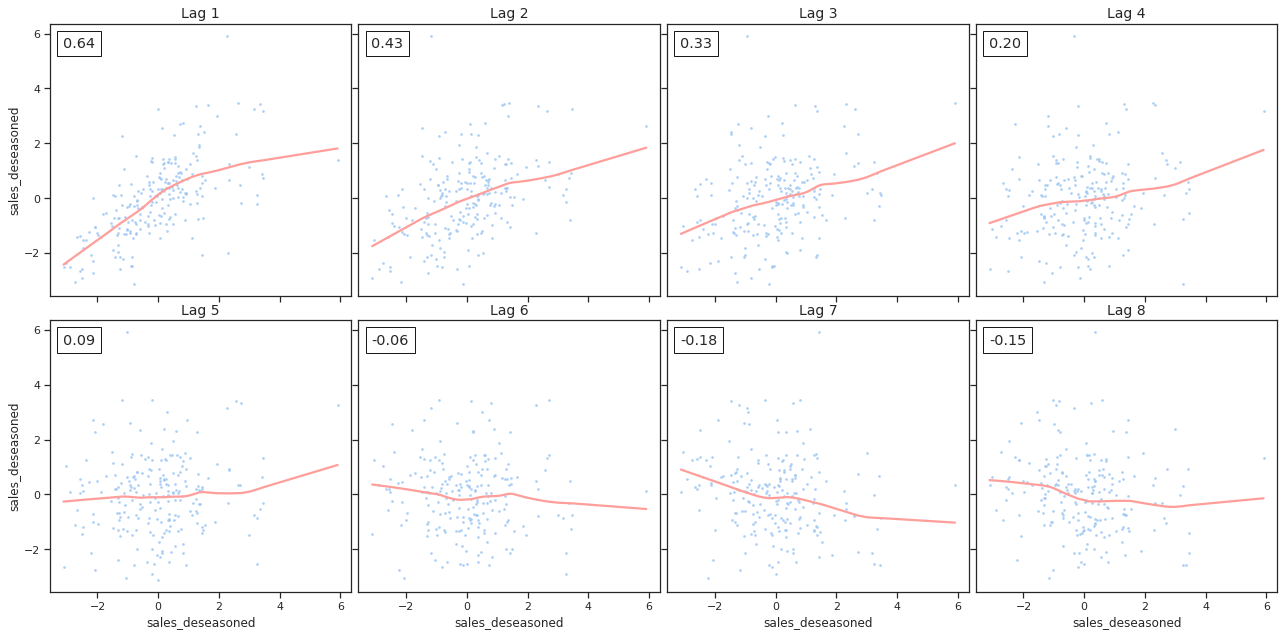

In [42]:
_ = plot_lags(y_deseason, lags=8, nrows=2)

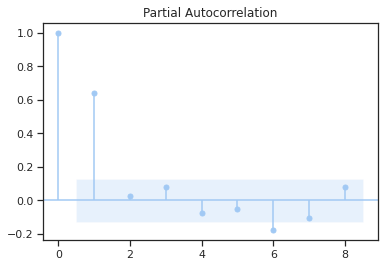

In [43]:
_ = plot_pacf(y_deseason, lags=8)

Here we examine leading and lagging values for **onpromotion** plotted against **magazine sales**.

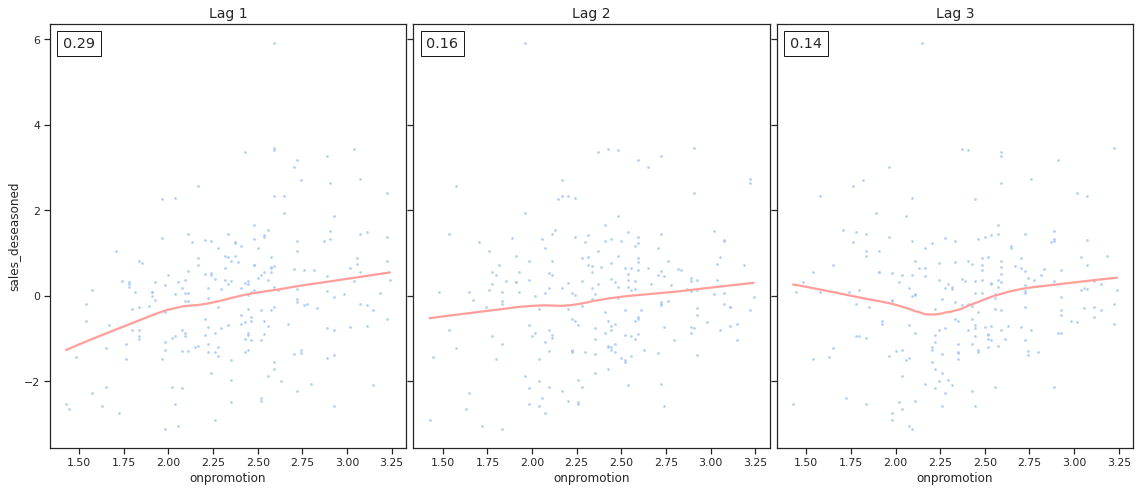

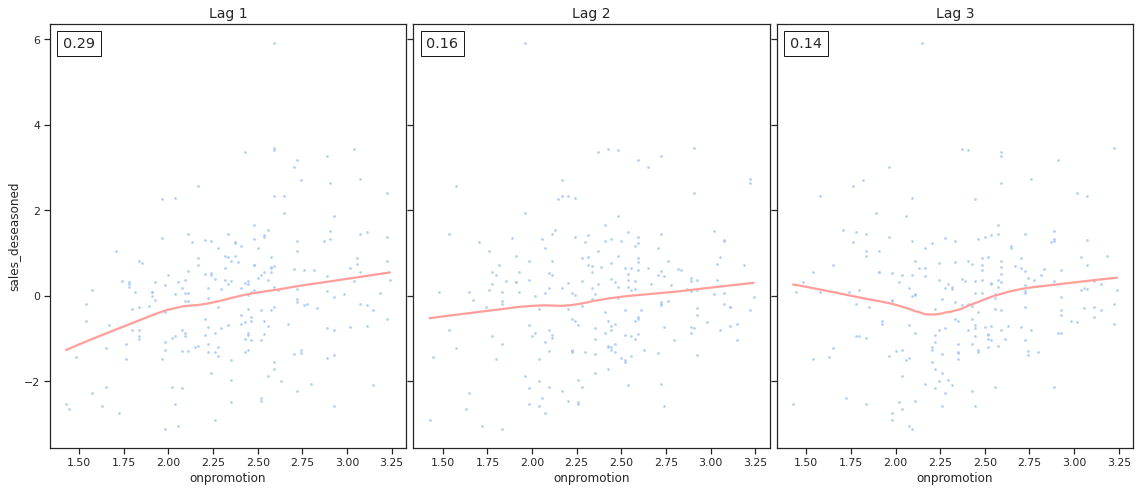

In [44]:
onpromotion = mag_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop the New Year outlier
plot_lags(x=onpromotion.iloc[1:], y=y_deseason.iloc[1:], lags=3, nrows=1)

# 4.2 Lags. Forecasting
After that, we can **make lags** for future plots.

In [45]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

In [46]:
X = make_lags(y_deseason, lags=4)
X = X.fillna(0.0)

And we can build plot with **predictions**:

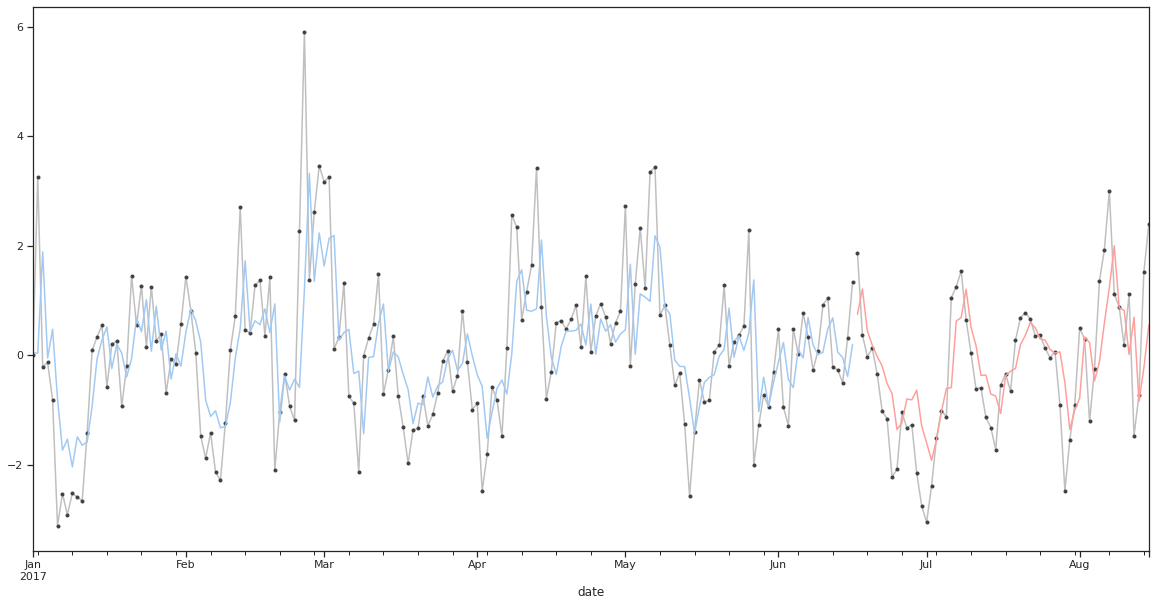

In [47]:
# Create target series and data splits
y = y_deseason.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax = y_train.plot(color="0.75", style=".-", markeredgecolor="0.25", markerfacecolor="0.25", ax=ax)
ax = y_test.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25", ax=ax)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')
plt.show()

# 5. Hybrid Models
Linear regression excels at extrapolating trends, but can't learn interactions. XGBoost excels at learning interactions, but can't extrapolate trends. Here we'll learn how to create **"hybrid" forecasters** that combine complementary learning algorithms and let the strengths of one make up for the weakness of the other.

In [48]:
store_sales = df_train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

Firslty, we should create **Boosted Hybrid class**:

In [49]:
# we'll add fit and predict methods to this minimal class
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

Also, we need to create **fit** method:

In [50]:
def fit(self, X_1, X_2, y):
    # train model_1
    self.model_1.fit(X_1, y)

    # make predictions
    y_fit = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=y.columns,
    )

    # compute residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # train model_2 on residuals
    self.model_2.fit(X_2, y_resid)

    # save column names for predict method
    self.y_columns = y.columns
    # Save data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid


# Add method to class
BoostedHybrid.fit = fit

And **predict** method:

In [51]:
def predict(self, X_1, X_2):
    # Predict with model_1
    y_pred = pd.DataFrame(
        self.model_1.predict(X_1), 
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long

    # Add model_2 predictions to model_1 predictions
    y_pred += self.model_2.predict(X_2)

    return y_pred.unstack()


# Add method to class
BoostedHybrid.predict = predict

Here we can **set up data for training**:

In [52]:
# Target series
y = family_sales.loc[:, 'sales']


# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

Here we can **train** our model:

In [53]:
# Create model
model = BoostedHybrid(
    model_1=LinearRegression(),
    model_2=XGBRegressor())

model.fit(X_1, X_2, y)

y_pred = model.predict(X_1, X_2)
y_pred = y_pred.clip(0.0)

In [54]:
# Boosted Hybrid
model = BoostedHybrid(
    model_1=Ridge(),
    model_2=KNeighborsRegressor(),
)

After that we train and plot

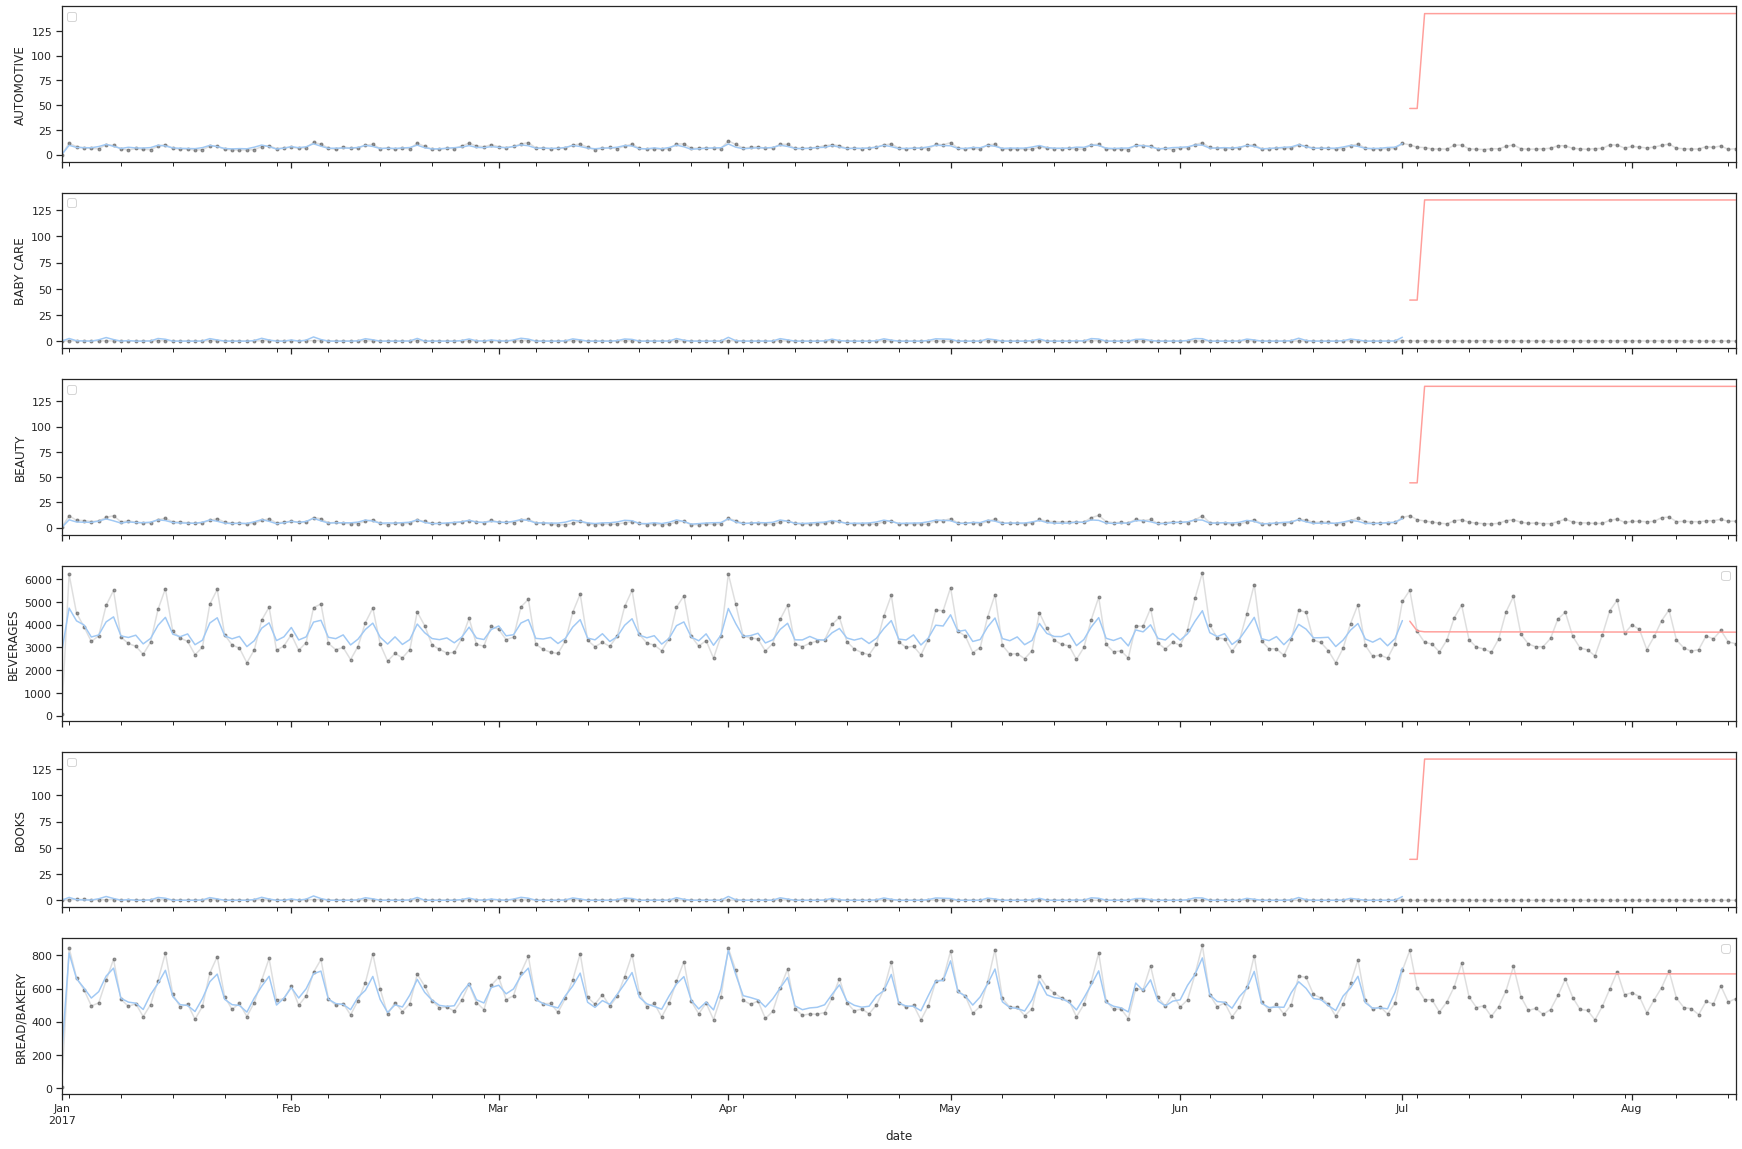

In [55]:
y_train, y_valid = y[:"2017-07-01"], y["2017-07-02":]
X1_train, X1_valid = X_1[: "2017-07-01"], X_1["2017-07-02" :]
X2_train, X2_valid = X_2.loc[:"2017-07-01"], X_2.loc["2017-07-02":]

# Some of the algorithms above do best with certain kinds of
# preprocessing on the features (like standardization), but this is
# just a demo.
model.fit(X1_train, X2_train, y_train)
y_fit = model.predict(X1_train, X2_train).clip(0.0)
y_pred = model.predict(X1_valid, X2_valid).clip(0.0)

families = y.columns[0:6]
axs = y.loc(axis=1)[families].plot(subplots=True, 
                                   sharex=True, 
                                   figsize=(30, 20), 
                                   color="0.75",
                                   style=".-",
                                   markeredgecolor="0.25",
                                   markerfacecolor="0.25",
                                   alpha=0.5)
_ = y_fit.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C0', ax=axs)
_ = y_pred.loc(axis=1)[families].plot(subplots=True, sharex=True, color='C3', ax=axs)
for ax, family in zip(axs, families):
    ax.legend([])
    ax.set_ylabel(family)

# 6. Machine learning forecasting

In [56]:
# train data
store_sales = df_train.copy()
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

In [57]:
# test data
test = df_test.copy()
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [58]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)

In [59]:
y = family_sales.loc[:, 'sales']

# make 4 lag features
X = make_lags(y, lags=5).dropna()

# make multistep target
y = make_multistep_target(y, steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

Here we **prepare the data** for XGBoost:

In [60]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y) 

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     6.018519    10.259259     9.388889   
           BABY CARE                      0.277778     0.259259     0.240741   
           BEAUTY                         6.518519    10.037037    11.611111   
           BEVERAGES                   3507.277778  4848.518519  5503.648148   
           BOOKS                          0.537037     0.481481     0.722222   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955648   403.601334   377.313980   
           PREPARED FOODS                84.698648    87.836796    88.735963   
           PRODUCE                     2257.140589  2609.180150  3122.895724   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333333    57.481481   
           SEAFOOD                       20.488333    20.346852    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.944444     4.777778     6.314815   
           BABY CARE                      0.444444     0.240741     0.277778   
           BEAUTY                         5.648148     6.500000     5.277778   
           BEVERAGES                   3448.203704  3171.740741  3046.870370   
           BOOKS                          0.500000     0.518519     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436093   533.497054   416.454018   
           PREPARED FOODS                77.173000    91.886760   100.384963   
           PRODUCE                     1792.220910  2079.319469  2418.970157   
           SCHOOL AND OFFICE SUPPLIES    51.907407    63.222222    85.203704   
           SEAFOOD                       17.116296    25.553963    24.209519   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-06 AUTOMOTIVE                     5.388889     5.240741     8.500000   
           BABY CARE                      0.296296     0.296296     0.388889   
           BEAUTY                         4.370370     4.703704     7.777778   
           BEVERAGES                   2693.722222  3226.037037  4667.296296   
           BOOKS                          0.388889     0.444444     0.574074   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596557   344.051740   313.780869   
           PREPARED FOODS               102.248148    86.627444    77.344130   
           PRODUCE                     2675.105815  2111.133423  2168.535465   
           SCHOOL AND OFFICE SUPPLIES   100.277778    64.407407    59.759259   
           SEAFOOD                       23.512852    18.419852    18.481130   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-06 AUTOMOTIVE                    10.259259     6.407407     5.685185   
           BABY CARE                      0.425926     0.314815     0.166667   
           BEAUTY                         9.037037     5.648148     5.351852   
           BEVERAGES                   5580.611111  3700.370370  3409.796296   
           BOOKS                          0.555556     0.388889     0.500000   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270204   278.819870   468.857370   
           PREPARED FOODS                84.796537    78.791444    96.286926   
           PRODUCE                     2663.076241  1670.264889  2198.854500   
           SCHOOL AND OFFICE SUPPLIES  

# 6.1 Forecast with the DirRec strategy
Instatiate a model that applies the DirRec strategy to XGBoost.

In [61]:
# init model
model = RegressorChain(base_estimator=XGBRegressor())

In [62]:
# train model
model.fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index,columns=y.columns).clip(0.0)

Also, we need to define helpfull function, **plot_multistep**:

In [63]:
# helpful function
def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

So, now, we can **plot results**:

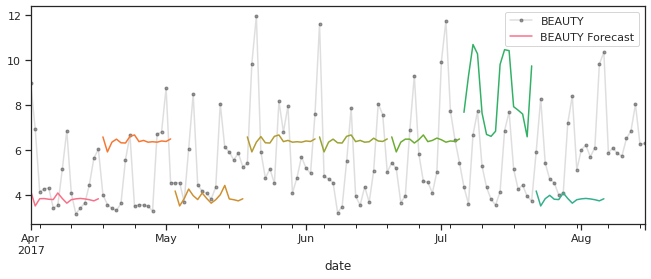

In [64]:
FAMILY = 'BEAUTY'
START = '2017-04-01'
EVERY = 16

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(color="0.75",style=".-",markeredgecolor="0.25", markerfacecolor="0.25",ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

# 7. Conclusion
Thank you for reading my new article!

Hope, you liked it and it was interesting for you! There are some more my articles:
* [SMS spam with NBC | NLP | sklearn](https://www.kaggle.com/maricinnamon/sms-spam-with-nbc-nlp-sklearn)
* [House Prices Regression sklearn](https://www.kaggle.com/maricinnamon/house-prices-regression-sklearn)
* [Automobile Customer Clustering (K-means & PCA)](https://www.kaggle.com/maricinnamon/automobile-customer-clustering-k-means-pca)
* [Credit Card Fraud detection sklearn](https://www.kaggle.com/maricinnamon/credit-card-fraud-detection-sklearn)
* [Market Basket Analysis for beginners](https://www.kaggle.com/maricinnamon/market-basket-analysis-for-beginners)
* [Neural Network for beginners with keras](https://www.kaggle.com/maricinnamon/neural-network-for-beginners-with-keras)
* [Fetal Health Classification for beginners sklearn](https://www.kaggle.com/maricinnamon/fetal-health-classification-for-beginners-sklearn)
* [Retail Trade Report Department Stores (LSTM)](https://www.kaggle.com/maricinnamon/retail-trade-report-department-stores-lstm)

**IF YOU LIKED THIS ARTICLE ABOUT TIME SERIES, PLEASE, MAKE AN UPVOTE ❤️**